In [93]:
# Bibliotecas 
import keras
import tqdm
import logging
from sklearn.model_selection import LeaveOneOut, KFold
from pydotplus import graphviz
from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
import tensorflow as tf
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline
from keras import models
from numpy import int64
from keras.models import Sequential, Model
from keras.losses import binary_crossentropy
from tensorflow.keras.utils  import plot_model
from keras import layers
from keras.layers import Dense, Input, concatenate
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [94]:
!pip install keras-rectified-adam

Defaulting to user installation because normal site-packages is not writeable


In [95]:
from keras_radam import RAdam

In [96]:
#Configuração
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import logging, os
logging.disable(logging.WARNING)
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

### Configrando o Trem de Michalski

In [97]:
df = pd.read_csv('trains/trains-transformed.csv')
df

,Number_of_cars,Number_of_different_loads,num_wheels1,length1,shape1,num_loads1,load_shape1,num_wheels2,length2,shape2,...,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute
0,5,4,2,long,openrect,3,rectanglod,2,short,slopetop,...,1,0,0,0,1,0,0,1,0,east
1,4,3,2,short,ushaped,1,trianglod,2,short,opentrap,...,1,0,1,0,0,0,0,0,0,east
2,4,2,2,short,openrect,1,circlelod,2,short,hexagon,...,0,0,0,1,0,1,0,0,0,east
3,5,2,2,short,opentrap,1,trianglod,2,short,dblopnrect,...,1,0,0,1,0,0,0,0,0,east
4,4,3,2,short,dblopnrect,1,trianglod,3,long,closedrect,...,1,0,1,0,0,0,0,0,0,east
5,3,2,2,long,closedrect,3,circlelod,2,short,openrect,...,0,0,0,0,0,1,0,0,0,west
6,4,2,2,short,dblopnrect,1,circlelod,2,short,ushaped,...,0,0,0,0,0,1,0,0,0,west
7,3,2,3,long,closedrect,1,rectanglod,2,short,ushaped,...,0,0,1,0,0,0,0,0,0,west
8,5,2,2,short,opentrap,1,circlelod,2,long,jaggedtop,...,0,0,1,0,0,0,0,0,0,west
9,3,1,2,short,ushaped,1,rectanglod,2,long,openrect,...,0,0,0,0,0,0,0,0,0,west


In [98]:
# Função para realizar as modificações da base 
str_att = {
  'length': ['short', 'long'],
  'shape': ['closedrect', 'dblopnrect', 'ellipse', 'engine', 'hexagon',
          'jaggedtop', 'openrect', 'opentrap', 'slopetop', 'ushaped'],
  'load_shape': ['circlelod', 'hexagonlod', 'rectanglod', 'trianglod'],
  'Class_attribute': ['west','east']
}

def read_data(df):

  for k in df:
    for att in str_att:
      if k.startswith(att):
        for i,val in enumerate(df[k]):
          if val in str_att[att]:
            df[k][i] = str_att[att].index(val)

  df.replace("\\0", 0, inplace=True)
  df.replace("None", -1, inplace=True)

  return df

In [99]:
# base após as modificações
df = read_data(df).fillna(-1)
df

,Number_of_cars,Number_of_different_loads,num_wheels1,length1,shape1,num_loads1,load_shape1,num_wheels2,length2,shape2,...,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute
0,5,4,2,1,6,3,2,2,0,8,...,1,0,0,0,1,0,0,1,0,1
1,4,3,2,0,9,1,3,2,0,7,...,1,0,1,0,0,0,0,0,0,1
2,4,2,2,0,6,1,0,2,0,4,...,0,0,0,1,0,1,0,0,0,1
3,5,2,2,0,7,1,3,2,0,1,...,1,0,0,1,0,0,0,0,0,1
4,4,3,2,0,1,1,3,3,1,0,...,1,0,1,0,0,0,0,0,0,1
5,3,2,2,1,0,3,0,2,0,6,...,0,0,0,0,0,1,0,0,0,0
6,4,2,2,0,1,1,0,2,0,9,...,0,0,0,0,0,1,0,0,0,0
7,3,2,3,1,0,1,2,2,0,9,...,0,0,1,0,0,0,0,0,0,0
8,5,2,2,0,7,1,0,2,1,5,...,0,0,1,0,0,0,0,0,0,0
9,3,1,2,0,9,1,2,2,1,6,...,0,0,0,0,0,0,0,0,0,0


## Questão 1

#### Questão 1. Implemente uma rede neural que classifique quando um dado trem vai para o leste ou oeste. Você  pode usar como função de ativação da camada de saída uma tangente hiperbólica e usar saída "1" para leste e "-1" para oeste. 

In [100]:
y_train = df['Class_attribute']

X_train = df.drop('Class_attribute', axis=1)


In [101]:
y_train

0    1
1    1
2    1
3    1
4    1
5    0
6    0
7    0
8    0
9    0
Name: Class_attribute, dtype: int64

In [102]:
#Necessario realizar o reshape para que o objeto possa ser transposto para tensor
x = np.asarray(X_train).astype('float32')

In [103]:
x

array([[ 5.,  4.,  2.,  1.,  6.,  3.,  2.,  2.,  0.,  8.,  1.,  3.,  3.,
         1.,  6.,  1.,  1.,  2.,  0.,  6.,  1.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.],
       [ 4.,  3.,  2.,  0.,  9.,  1.,  3.,  2.,  0.,  7.,  1.,  2.,  2.,
         0.,  0.,  2.,  0., -1., -1., -1., -1., -1.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  2.,  2.,  0.,  6.,  1.,  0.,  2.,  0.,  4.,  1.,  3.,  3.,
         1.,  0.,  1.,  3., -1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.],
       [ 5.,  2.,  2.,  0.,  7.,  1.,  3.,  2.,  0.,  1.,  1.,  3.,  2.,
         0.,  2.,  1.,  2.,  2.,  0.,  6.,  1.,  2.,  1.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  3.,  2.,  0.,  1.,  1.,  3.,  3.,  1.,  0.,  1.,  2.,  2.,
         0.,  0.,  1.,  0., -1., -1., -1., -1., -1.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  2.,  2.,  1.,  0.,  3.,  0.,  2.,  0.,  6.,  1.,  3., -1.,
  

In [104]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y_train, test_size=0.2,random_state=42)

In [105]:
#criando modelo de rede neural 
network = models.Sequential()
network.add(layers.Dense(36, activation='relu', input_shape=(32,)))
network.add(layers.Dense(1, activation='tanh'))
network.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 36)                1188      
                                                                 
 dense_31 (Dense)            (None, 1)                 37        
                                                                 
Total params: 1,225
Trainable params: 1,225
Non-trainable params: 0
_________________________________________________________________


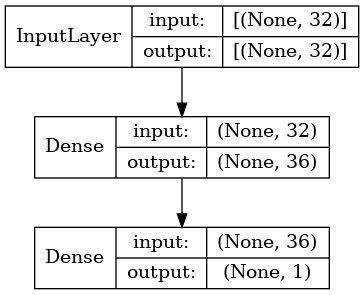

In [106]:
# Mostra o modelo
plot_model(network, show_shapes=True, show_layer_names=False)

# Treinando o Modelo

In [107]:
# Função para treinar o modelo e compilar
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
network.compile(
                optimizer=optimizer, 
                loss='mse', 
                metrics=['accuracy'])
H = network.fit(X_train, Y_train, epochs=50,validation_data =(X_test,Y_test),batch_size=1)

Epoch 1/50
8/8 [==============================] - 1s 54ms/step - loss: 0.9974 - accuracy: 0.6250 - val_loss: 0.9669 - val_accuracy: 0.0000e+00
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.5051 - accuracy: 0.6250 - val_loss: 0.6370 - val_accuracy: 0.0000e+00
Epoch 3/50
8/8 [==============================] - 0s 20ms/step - loss: 0.3170 - accuracy: 0.7500 - val_loss: 0.5305 - val_accuracy: 0.5000
Epoch 4/50
8/8 [==============================] - 0s 11ms/step - loss: 0.1878 - accuracy: 0.7500 - val_loss: 0.5091 - val_accuracy: 0.5000
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.1770 - accuracy: 0.7500 - val_loss: 0.5041 - val_accuracy: 0.5000
Epoch 6/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1517 - accuracy: 0.7500 - val_loss: 0.5055 - val_accuracy: 0.5000
Epoch 7/50
8/8 [==============================] - 0s 12ms/step - loss: 0.1353 - accuracy: 0.8750 - val_loss: 0.5133 - val_accuracy: 0.5000
Epoch 8/50
8/8 [===

2023-07-04 03:03:13.273971: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled


8/8 [==============================] - 0s 17ms/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.5308 - val_accuracy: 0.5000
Epoch 18/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.5323 - val_accuracy: 0.5000
Epoch 19/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.5304 - val_accuracy: 0.5000
Epoch 20/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.5311 - val_accuracy: 0.5000
Epoch 21/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.5299 - val_accuracy: 0.5000
Epoch 22/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.5290 - val_accuracy: 0.5000
Epoch 23/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.5291 - val_accuracy: 0.5000
Epoch 24/50
8/8 [=================

# Saídas

In [108]:
# Função para avaliar a precisão do modelo usando o seguinte código:

if __name__ == '__main__':
    x = np.random.rand(100, 32)
    y_train = np.random.randint(2, size=100) * 2 - 1

    X_train, X_test, Y_train, Y_test = train_test_split(x, y_train, test_size=0.2, random_state=42)

y_pred = network.predict(X_test)
loss, accuracy = network.evaluate(X_test, y_pred)
print("Loss:", loss)
print("Accuracy:", accuracy)

1/1 [==============================] - 0s 106ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Loss: 0.0
Accuracy: 0.0


In [109]:
# Função para verificar se a saída da camada é -1 ou 1. Como está entre -1 e 1, convertendo temos:
y_pred = network.predict(X_test)
y_pred = np.where(y_pred >= 0.5, 1, -1)


1/1 [==============================] - 0s 31ms/step


In [110]:
history_dict = H.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

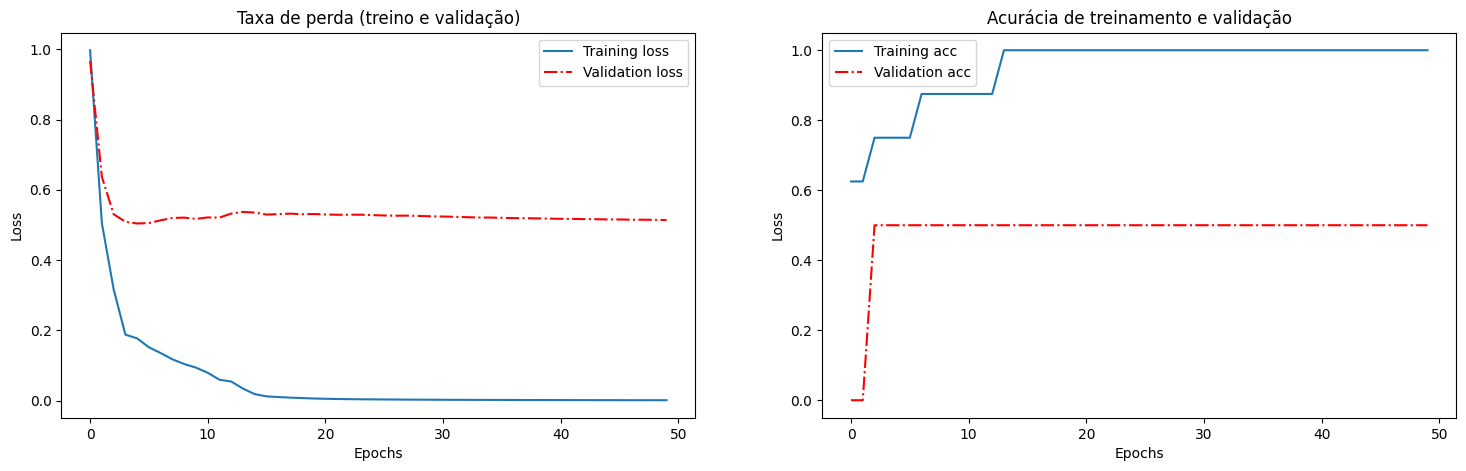

In [111]:
# Plotar o gŕafico
import matplotlib.pyplot as plt
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
epochs = range(0, 50)
loss = H.history['loss']
val_loss = H.history['val_loss']
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, '-.r', label='Validation loss')
plt.title('Taxa de perda (treino e validação)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, '-.r', label='Validation acc')
plt.title('Acurácia de treinamento e validação')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 1.1.a

Deixe de fora do treinamento da	rede: um trem indo para oeste e	dois (2) casos para	leste,	se	i<5	 então	pegue casoi	e casoi+1
senão pegue	caso casoi e casoi-4(primeiro	e	ultimo	casos)

In [112]:
df = pd.read_csv('trains/trains-transformed-1.1.a.csv')
df

,Number_of_cars,Number_of_different_loads,num_wheels1,length1,shape1,num_loads1,load_shape1,num_wheels2,length2,shape2,...,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute
0,4,2,2,short,openrect,1,circlelod,2,short,hexagon,...,0,0,0,1,0,1,0,0,0,east
1,5,2,2,short,opentrap,1,trianglod,2,short,dblopnrect,...,1,0,0,1,0,0,0,0,0,east
2,4,3,2,short,dblopnrect,1,trianglod,3,long,closedrect,...,1,0,1,0,0,0,0,0,0,east
3,3,2,2,long,closedrect,3,circlelod,2,short,openrect,...,0,0,0,0,0,1,0,0,0,west
4,4,2,2,short,dblopnrect,1,circlelod,2,short,ushaped,...,0,0,0,0,0,1,0,0,0,west
5,3,2,3,long,closedrect,1,rectanglod,2,short,ushaped,...,0,0,1,0,0,0,0,0,0,west
6,5,2,2,short,opentrap,1,circlelod,2,long,jaggedtop,...,0,0,1,0,0,0,0,0,0,west


In [113]:
# Função para realizar as modificações da base 
str_att = {
  'length': ['short', 'long'],
  'shape': ['closedrect', 'dblopnrect', 'ellipse', 'engine', 'hexagon',
          'jaggedtop', 'openrect', 'opentrap', 'slopetop', 'ushaped'],
  'load_shape': ['circlelod', 'hexagonlod', 'rectanglod', 'trianglod'],
  'Class_attribute': ['west','east']
}

def read_data(df):

  for k in df:
    for att in str_att:
      if k.startswith(att):
        for i,val in enumerate(df[k]):
          if val in str_att[att]:
            df[k][i] = str_att[att].index(val)

  df.replace("\\0", 0, inplace=True)
  df.replace("None", -1, inplace=True)

  return df

In [114]:
# base após as modificações
df = read_data(df).fillna(-1)
df

,Number_of_cars,Number_of_different_loads,num_wheels1,length1,shape1,num_loads1,load_shape1,num_wheels2,length2,shape2,...,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute
0,4,2,2,0,6,1,0,2,0,4,...,0,0,0,1,0,1,0,0,0,1
1,5,2,2,0,7,1,3,2,0,1,...,1,0,0,1,0,0,0,0,0,1
2,4,3,2,0,1,1,3,3,1,0,...,1,0,1,0,0,0,0,0,0,1
3,3,2,2,1,0,3,0,2,0,6,...,0,0,0,0,0,1,0,0,0,0
4,4,2,2,0,1,1,0,2,0,9,...,0,0,0,0,0,1,0,0,0,0
5,3,2,3,1,0,1,2,2,0,9,...,0,0,1,0,0,0,0,0,0,0
6,5,2,2,0,7,1,0,2,1,5,...,0,0,1,0,0,0,0,0,0,0


In [115]:
y_train = df['Class_attribute']

X_train = df.drop('Class_attribute', axis=1)

y_train

0    1
1    1
2    1
3    0
4    0
5    0
6    0
Name: Class_attribute, dtype: int64

In [116]:
#Necessario realizar o reshape para que o objeto possa ser transposto para tensor
x = np.asarray(X_train).astype('float32')
x

array([[ 4.,  2.,  2.,  0.,  6.,  1.,  0.,  2.,  0.,  4.,  1.,  3.,  3.,
         1.,  0.,  1.,  3., -1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.],
       [ 5.,  2.,  2.,  0.,  7.,  1.,  3.,  2.,  0.,  1.,  1.,  3.,  2.,
         0.,  2.,  1.,  2.,  2.,  0.,  6.,  1.,  2.,  1.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  3.,  2.,  0.,  1.,  1.,  3.,  3.,  1.,  0.,  1.,  2.,  2.,
         0.,  0.,  1.,  0., -1., -1., -1., -1., -1.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  2.,  2.,  1.,  0.,  3.,  0.,  2.,  0.,  6.,  1.,  3., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.],
       [ 4.,  2.,  2.,  0.,  1.,  1.,  0.,  2.,  0.,  9.,  1.,  3.,  2.,
         1.,  5.,  0., -1., -1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.],
       [ 3.,  2.,  3.,  1.,  0.,  1.,  2.,  2.,  0.,  9.,  1.,  0., -1.,
  

In [117]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y_train, test_size=0.2,random_state=42)
#criando modelo de rede neural 
network = models.Sequential()
network.add(layers.Dense(36, activation='relu', input_shape=(32,)))
network.add(layers.Dense(1, activation='tanh'))
network.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 36)                1188      
                                                                 
 dense_33 (Dense)            (None, 1)                 37        
                                                                 
Total params: 1,225
Trainable params: 1,225
Non-trainable params: 0
_________________________________________________________________


In [118]:
#treina o modelo e compila
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
network.compile(
                optimizer=optimizer, 
                loss='mse', 
                metrics=['accuracy'])
H = network.fit(X_train, Y_train, epochs=50,validation_data =(X_test,Y_test),batch_size=1)

Epoch 1/50
5/5 [==============================] - 1s 43ms/step - loss: 1.1927 - accuracy: 0.6000 - val_loss: 3.9514 - val_accuracy: 0.0000e+00
Epoch 2/50
5/5 [==============================] - 0s 21ms/step - loss: 0.9444 - accuracy: 0.6000 - val_loss: 3.8890 - val_accuracy: 0.0000e+00
Epoch 3/50
5/5 [==============================] - 0s 21ms/step - loss: 0.7028 - accuracy: 0.6000 - val_loss: 3.8313 - val_accuracy: 0.0000e+00
Epoch 4/50
5/5 [==============================] - 0s 18ms/step - loss: 0.6085 - accuracy: 0.6000 - val_loss: 3.7732 - val_accuracy: 0.0000e+00
Epoch 5/50
5/5 [==============================] - 0s 13ms/step - loss: 0.4113 - accuracy: 0.6000 - val_loss: 3.7317 - val_accuracy: 0.0000e+00
Epoch 6/50
5/5 [==============================] - 0s 11ms/step - loss: 0.3115 - accuracy: 0.6000 - val_loss: 3.7161 - val_accuracy: 0.0000e+00
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 0.2465 - accuracy: 0.8000 - val_loss: 3.7108 - val_accuracy: 0.0000e+00

In [119]:
# Função para avaliar a precisão do modelo usando o seguinte código:

if __name__ == '__main__':
    x = np.random.rand(100, 32)
    y_train = np.random.randint(2, size=100) * 2 - 1

    X_train, X_test, Y_train, Y_test = train_test_split(x, y_train, test_size=0.2, random_state=42)

y_pred = network.predict(X_test)
loss, accuracy = network.evaluate(X_test, y_pred)
print("Loss:", loss)
print("Accuracy:", accuracy)

1/1 [==============================] - 0s 164ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Loss: 0.0
Accuracy: 0.0


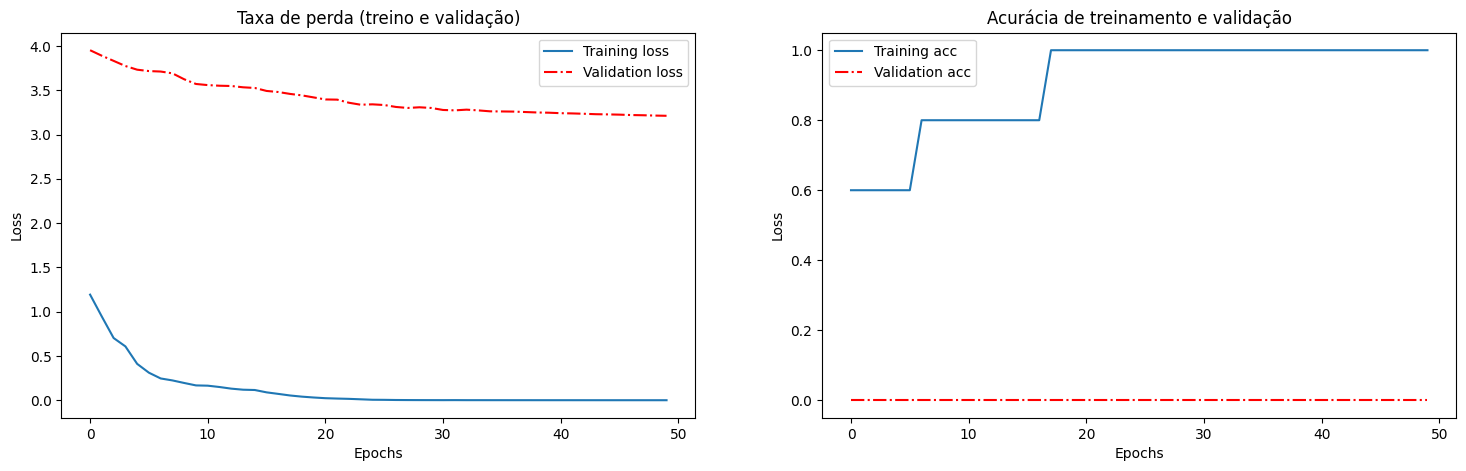

In [120]:
# Plotar o gŕafico
import matplotlib.pyplot as plt
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
epochs = range(0, 50)
loss = H.history['loss']
val_loss = H.history['val_loss']
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, '-.r', label='Validation loss')
plt.title('Taxa de perda (treino e validação)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, '-.r', label='Validation acc')
plt.title('Acurácia de treinamento e validação')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 1.1.b

Treine a sua rede com os casos restantes

In [121]:
df = pd.read_csv('trains/trains-transformed-1.1.b.csv')
df

,Number_of_cars,Number_of_different_loads,num_wheels1,length1,shape1,num_loads1,load_shape1,num_wheels2,length2,shape2,...,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute
0,5,4,2,long,openrect,3,rectanglod,2,short,slopetop,...,1,0,0,0,1,0,0,1,0,east
1,4,3,2,short,ushaped,1,trianglod,2,short,opentrap,...,1,0,1,0,0,0,0,0,0,east
2,4,2,2,short,openrect,1,circlelod,2,short,hexagon,...,0,0,0,1,0,1,0,0,0,east
3,5,2,2,short,opentrap,1,trianglod,2,short,dblopnrect,...,1,0,0,1,0,0,0,0,0,east
4,4,3,2,short,dblopnrect,1,trianglod,3,long,closedrect,...,1,0,1,0,0,0,0,0,0,east
5,3,2,2,long,closedrect,3,circlelod,2,short,openrect,...,0,0,0,0,0,1,0,0,0,east
6,4,2,2,short,dblopnrect,1,circlelod,2,short,ushaped,...,0,0,0,0,0,1,0,0,0,west
7,3,2,3,long,closedrect,1,rectanglod,2,short,ushaped,...,0,0,1,0,0,0,0,0,0,west
8,5,2,2,short,opentrap,1,circlelod,2,long,jaggedtop,...,0,0,1,0,0,0,0,0,0,west
9,3,1,2,short,ushaped,1,rectanglod,2,long,openrect,...,0,0,0,0,0,0,0,0,0,east


In [122]:
# Função para realizar as modificações da base 
str_att = {
  'length': ['short', 'long'],
  'shape': ['closedrect', 'dblopnrect', 'ellipse', 'engine', 'hexagon',
          'jaggedtop', 'openrect', 'opentrap', 'slopetop', 'ushaped'],
  'load_shape': ['circlelod', 'hexagonlod', 'rectanglod', 'trianglod'],
  'Class_attribute': ['west','east']
}

def read_data(df):

  for k in df:
    for att in str_att:
      if k.startswith(att):
        for i,val in enumerate(df[k]):
          if val in str_att[att]:
            df[k][i] = str_att[att].index(val)

  df.replace("\\0", 0, inplace=True)
  df.replace("None", -1, inplace=True)

  return df

In [123]:
# base após as modificações
df = read_data(df).fillna(-1)
df

,Number_of_cars,Number_of_different_loads,num_wheels1,length1,shape1,num_loads1,load_shape1,num_wheels2,length2,shape2,...,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute
0,5,4,2,1,6,3,2,2,0,8,...,1,0,0,0,1,0,0,1,0,1
1,4,3,2,0,9,1,3,2,0,7,...,1,0,1,0,0,0,0,0,0,1
2,4,2,2,0,6,1,0,2,0,4,...,0,0,0,1,0,1,0,0,0,1
3,5,2,2,0,7,1,3,2,0,1,...,1,0,0,1,0,0,0,0,0,1
4,4,3,2,0,1,1,3,3,1,0,...,1,0,1,0,0,0,0,0,0,1
5,3,2,2,1,0,3,0,2,0,6,...,0,0,0,0,0,1,0,0,0,1
6,4,2,2,0,1,1,0,2,0,9,...,0,0,0,0,0,1,0,0,0,0
7,3,2,3,1,0,1,2,2,0,9,...,0,0,1,0,0,0,0,0,0,0
8,5,2,2,0,7,1,0,2,1,5,...,0,0,1,0,0,0,0,0,0,0
9,3,1,2,0,9,1,2,2,1,6,...,0,0,0,0,0,0,0,0,0,1


In [124]:
y_train = df['Class_attribute']

X_train = df.drop('Class_attribute', axis=1)

y_train

0    1
1    1
2    1
3    1
4    1
5    1
6    0
7    0
8    0
9    1
Name: Class_attribute, dtype: int64

In [125]:
#Necessario realizar o reshape para que o objeto possa ser transposto para tensor
x = np.asarray(X_train).astype('float32')
x

array([[ 5.,  4.,  2.,  1.,  6.,  3.,  2.,  2.,  0.,  8.,  1.,  3.,  3.,
         1.,  6.,  1.,  1.,  2.,  0.,  6.,  1.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.],
       [ 4.,  3.,  2.,  0.,  9.,  1.,  3.,  2.,  0.,  7.,  1.,  2.,  2.,
         0.,  0.,  2.,  0., -1., -1., -1., -1., -1.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  2.,  2.,  0.,  6.,  1.,  0.,  2.,  0.,  4.,  1.,  3.,  3.,
         1.,  0.,  1.,  3., -1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.],
       [ 5.,  2.,  2.,  0.,  7.,  1.,  3.,  2.,  0.,  1.,  1.,  3.,  2.,
         0.,  2.,  1.,  2.,  2.,  0.,  6.,  1.,  2.,  1.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  3.,  2.,  0.,  1.,  1.,  3.,  3.,  1.,  0.,  1.,  2.,  2.,
         0.,  0.,  1.,  0., -1., -1., -1., -1., -1.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  2.,  2.,  1.,  0.,  3.,  0.,  2.,  0.,  6.,  1.,  3., -1.,
  

In [126]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y_train, test_size=0.2,random_state=42)
#criando modelo de rede neural 
network = models.Sequential()
network.add(layers.Dense(36, activation='relu', input_shape=(32,)))
network.add(layers.Dense(1, activation='tanh'))
network.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 36)                1188      
                                                                 
 dense_35 (Dense)            (None, 1)                 37        
                                                                 
Total params: 1,225
Trainable params: 1,225
Non-trainable params: 0
_________________________________________________________________


In [127]:
#treina o modelo e compila
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
network.compile(
                optimizer=optimizer, 
                loss='mse', 
                metrics=['accuracy'])
H = network.fit(X_train, Y_train, epochs=50,validation_data =(X_test,Y_test),batch_size=1)

Epoch 1/50
8/8 [==============================] - 2s 23ms/step - loss: 0.2653 - accuracy: 0.7500 - val_loss: 0.4976 - val_accuracy: 0.5000
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.2530 - accuracy: 0.7500 - val_loss: 0.4987 - val_accuracy: 0.5000
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.2522 - accuracy: 0.7500 - val_loss: 0.4991 - val_accuracy: 0.5000
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.2506 - accuracy: 0.7500 - val_loss: 0.4993 - val_accuracy: 0.5000
Epoch 5/50
8/8 [==============================] - 0s 7ms/step - loss: 0.2504 - accuracy: 0.7500 - val_loss: 0.4994 - val_accuracy: 0.5000
Epoch 6/50
8/8 [==============================] - 0s 7ms/step - loss: 0.2503 - accuracy: 0.7500 - val_loss: 0.4994 - val_accuracy: 0.5000
Epoch 7/50
8/8 [==============================] - 0s 8ms/step - loss: 0.2502 - accuracy: 0.7500 - val_loss: 0.4994 - val_accuracy: 0.5000
Epoch 8/50
8/8 [================

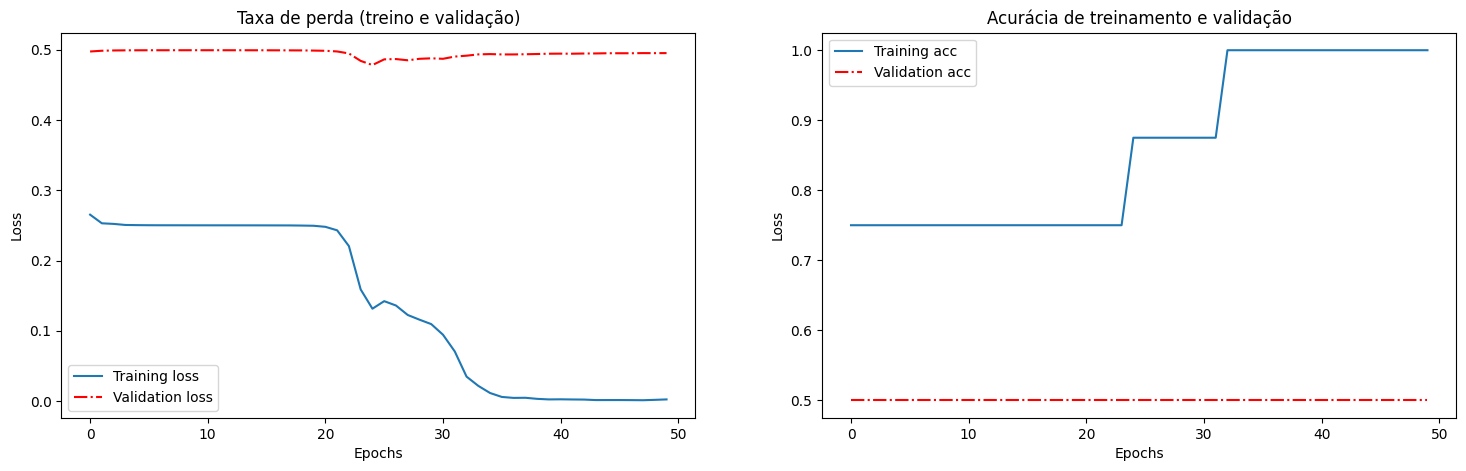

In [128]:
# Plotar o gŕafico
import matplotlib.pyplot as plt
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
epochs = range(0, 50)
loss = H.history['loss']
val_loss = H.history['val_loss']
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, '-.r', label='Validation loss')
plt.title('Taxa de perda (treino e validação)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, '-.r', label='Validation acc')
plt.title('Acurácia de treinamento e validação')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 1.1.c

teste	sua	rede	com	os	casos	selecionados	(no	caso	3)

In [129]:
df = pd.read_csv('trains/trains-transformed-1.1.b.csv')
df

,Number_of_cars,Number_of_different_loads,num_wheels1,length1,shape1,num_loads1,load_shape1,num_wheels2,length2,shape2,...,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute
0,5,4,2,long,openrect,3,rectanglod,2,short,slopetop,...,1,0,0,0,1,0,0,1,0,east
1,4,3,2,short,ushaped,1,trianglod,2,short,opentrap,...,1,0,1,0,0,0,0,0,0,east
2,4,2,2,short,openrect,1,circlelod,2,short,hexagon,...,0,0,0,1,0,1,0,0,0,east
3,5,2,2,short,opentrap,1,trianglod,2,short,dblopnrect,...,1,0,0,1,0,0,0,0,0,east
4,4,3,2,short,dblopnrect,1,trianglod,3,long,closedrect,...,1,0,1,0,0,0,0,0,0,east
5,3,2,2,long,closedrect,3,circlelod,2,short,openrect,...,0,0,0,0,0,1,0,0,0,east
6,4,2,2,short,dblopnrect,1,circlelod,2,short,ushaped,...,0,0,0,0,0,1,0,0,0,west
7,3,2,3,long,closedrect,1,rectanglod,2,short,ushaped,...,0,0,1,0,0,0,0,0,0,west
8,5,2,2,short,opentrap,1,circlelod,2,long,jaggedtop,...,0,0,1,0,0,0,0,0,0,west
9,3,1,2,short,ushaped,1,rectanglod,2,long,openrect,...,0,0,0,0,0,0,0,0,0,east


In [130]:
# Função para realizar as modificações da base 
str_att = {
  'length': ['short', 'long'],
  'shape': ['closedrect', 'dblopnrect', 'ellipse', 'engine', 'hexagon',
          'jaggedtop', 'openrect', 'opentrap', 'slopetop', 'ushaped'],
  'load_shape': ['circlelod', 'hexagonlod', 'rectanglod', 'trianglod'],
  'Class_attribute': ['west','east']
}

def read_data(df):

  for k in df:
    for att in str_att:
      if k.startswith(att):
        for i,val in enumerate(df[k]):
          if val in str_att[att]:
            df[k][i] = str_att[att].index(val)

  df.replace("\\0", 0, inplace=True)
  df.replace("None", -1, inplace=True)

  return df

In [131]:
# base após as modificações
df = read_data(df).fillna(-1)
df

,Number_of_cars,Number_of_different_loads,num_wheels1,length1,shape1,num_loads1,load_shape1,num_wheels2,length2,shape2,...,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute
0,5,4,2,1,6,3,2,2,0,8,...,1,0,0,0,1,0,0,1,0,1
1,4,3,2,0,9,1,3,2,0,7,...,1,0,1,0,0,0,0,0,0,1
2,4,2,2,0,6,1,0,2,0,4,...,0,0,0,1,0,1,0,0,0,1
3,5,2,2,0,7,1,3,2,0,1,...,1,0,0,1,0,0,0,0,0,1
4,4,3,2,0,1,1,3,3,1,0,...,1,0,1,0,0,0,0,0,0,1
5,3,2,2,1,0,3,0,2,0,6,...,0,0,0,0,0,1,0,0,0,1
6,4,2,2,0,1,1,0,2,0,9,...,0,0,0,0,0,1,0,0,0,0
7,3,2,3,1,0,1,2,2,0,9,...,0,0,1,0,0,0,0,0,0,0
8,5,2,2,0,7,1,0,2,1,5,...,0,0,1,0,0,0,0,0,0,0
9,3,1,2,0,9,1,2,2,1,6,...,0,0,0,0,0,0,0,0,0,1


In [132]:
y_train = df['Class_attribute']

X_train = df.drop('Class_attribute', axis=1)

y_train

0    1
1    1
2    1
3    1
4    1
5    1
6    0
7    0
8    0
9    1
Name: Class_attribute, dtype: int64

In [133]:
#Necessario realizar o reshape para que o objeto possa ser transposto para tensor
x = np.asarray(X_train).astype('float32')
x

array([[ 5.,  4.,  2.,  1.,  6.,  3.,  2.,  2.,  0.,  8.,  1.,  3.,  3.,
         1.,  6.,  1.,  1.,  2.,  0.,  6.,  1.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.],
       [ 4.,  3.,  2.,  0.,  9.,  1.,  3.,  2.,  0.,  7.,  1.,  2.,  2.,
         0.,  0.,  2.,  0., -1., -1., -1., -1., -1.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  2.,  2.,  0.,  6.,  1.,  0.,  2.,  0.,  4.,  1.,  3.,  3.,
         1.,  0.,  1.,  3., -1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.],
       [ 5.,  2.,  2.,  0.,  7.,  1.,  3.,  2.,  0.,  1.,  1.,  3.,  2.,
         0.,  2.,  1.,  2.,  2.,  0.,  6.,  1.,  2.,  1.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  3.,  2.,  0.,  1.,  1.,  3.,  3.,  1.,  0.,  1.,  2.,  2.,
         0.,  0.,  1.,  0., -1., -1., -1., -1., -1.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  2.,  2.,  1.,  0.,  3.,  0.,  2.,  0.,  6.,  1.,  3., -1.,
  

In [134]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y_train, test_size=0.2,random_state=42)
#criando modelo de rede neural 
network = models.Sequential()
network.add(layers.Dense(36, activation='relu', input_shape=(32,)))
network.add(layers.Dense(1, activation='tanh'))
network.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 36)                1188      
                                                                 
 dense_37 (Dense)            (None, 1)                 37        
                                                                 
Total params: 1,225
Trainable params: 1,225
Non-trainable params: 0
_________________________________________________________________


In [135]:
#treina o modelo e compila
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
network.compile(
                optimizer=optimizer, 
                loss='mse', 
                metrics=['accuracy'])
H = network.fit(X_train, Y_train, epochs=50,validation_data =(X_test,Y_test),batch_size=1)

Epoch 1/50
8/8 [==============================] - 1s 35ms/step - loss: 0.4583 - accuracy: 0.5000 - val_loss: 0.4096 - val_accuracy: 0.5000
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.2067 - accuracy: 0.7500 - val_loss: 0.4491 - val_accuracy: 0.5000
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.1809 - accuracy: 0.7500 - val_loss: 0.4660 - val_accuracy: 0.5000
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.1645 - accuracy: 0.7500 - val_loss: 0.4707 - val_accuracy: 0.5000
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.1412 - accuracy: 0.8750 - val_loss: 0.4720 - val_accuracy: 0.5000
Epoch 6/50
8/8 [==============================] - 0s 11ms/step - loss: 0.1303 - accuracy: 0.8750 - val_loss: 0.4714 - val_accuracy: 0.5000
Epoch 7/50
8/8 [==============================] - 0s 9ms/step - loss: 0.1285 - accuracy: 0.8750 - val_loss: 0.4704 - val_accuracy: 0.5000
Epoch 8/50
8/8 [==============

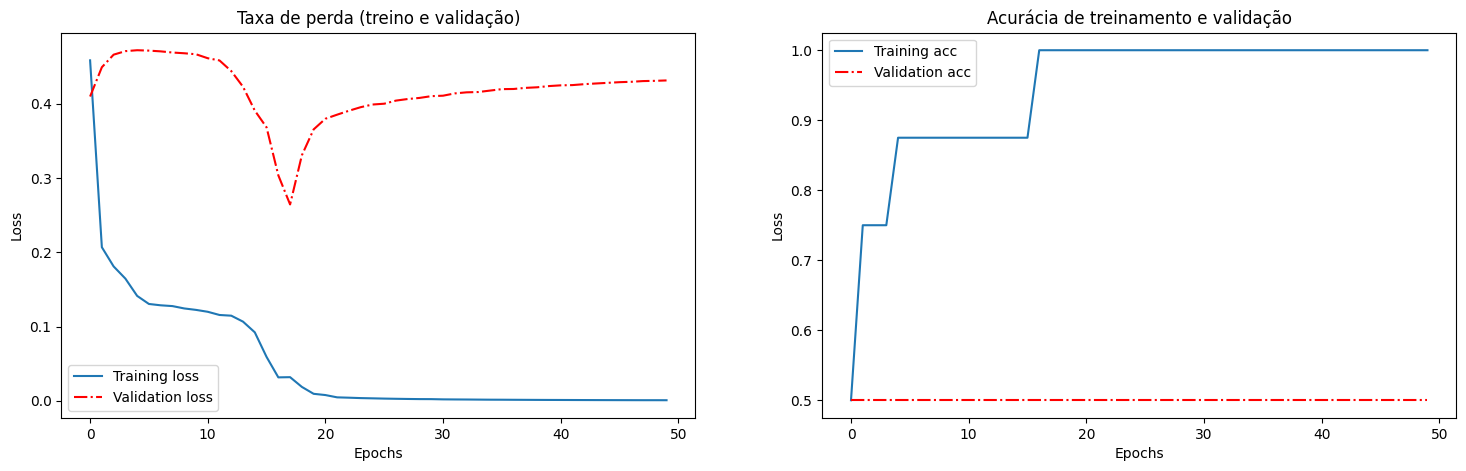

In [136]:
# Plotar o gŕafico
import matplotlib.pyplot as plt
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
epochs = range(0, 50)
loss = H.history['loss']
val_loss = H.history['val_loss']
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, '-.r', label='Validation loss')
plt.title('Taxa de perda (treino e validação)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, '-.r', label='Validation acc')
plt.title('Acurácia de treinamento e validação')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 1.2

Compare	a eficácia em casa experimento

Nos três experimentos, a perda de validação é menor que a perda de treinamento. Isso significa que as redes estão superajustando o conjunto de treinamento. O overfitting ocorre quando uma rede aprende muito bem os detalhes específicos do conjunto de treinamento e, como resultado, não generaliza bem para novos dados.

Dos três experimentos, o experimento 1.1(a) é a mais eficaz. A perda de validação da rede na imagem 1.1(a) é a menor, o que significa que é a menos overfit. Isso ocorre porque a rede no experimento 1.1(a) foi treinada para um menor período. Como resultado, a rede não foi capaz de aprender tantos detalhes específicos do conjunto de treinamento e, como resultado, é capaz de generalizar melhor para novos dados.

As redes no experimento 1.1(b) e 1.1(c) foram treinadas para mais tempo, o que lhes permitiu aprender mais detalhes específicos do conjunto de treinamento. No entanto, isso também fez com que eles superajustassem o conjunto de treinamento e, como resultado, eles não são tão eficazes quanto no experimento 1.1(a).

# 1.3.a

In [137]:
df = pd.read_csv('trains/trains-transformed-1.3.a.csv')
df

,Number_of_cars,Number_of_different_loads,num_wheels1,length1,shape1,num_loads1,load_shape1,num_wheels2,length2,shape2,...,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute
0,5,4,2,long,openrect,3,rectanglod,2,short,slopetop,...,1,0,0,0,1,0,0,1,0,east
1,4,3,2,short,ushaped,1,trianglod,2,short,opentrap,...,1,0,1,0,0,0,0,0,0,east
2,4,2,2,short,openrect,1,circlelod,2,short,hexagon,...,0,0,0,1,0,1,0,0,0,east
3,5,2,2,short,opentrap,1,trianglod,2,short,dblopnrect,...,1,0,0,1,0,0,0,0,0,east
4,3,2,2,long,closedrect,3,circlelod,2,short,openrect,...,0,0,0,0,0,1,0,0,0,west
5,4,2,2,short,dblopnrect,1,circlelod,2,short,ushaped,...,0,0,0,0,0,1,0,0,0,west
6,3,2,3,long,closedrect,1,rectanglod,2,short,ushaped,...,0,0,1,0,0,0,0,0,0,west


In [138]:
# Função para realizar as modificações da base 
str_att = {
  'length': ['short', 'long'],
  'shape': ['closedrect', 'dblopnrect', 'ellipse', 'engine', 'hexagon',
          'jaggedtop', 'openrect', 'opentrap', 'slopetop', 'ushaped'],
  'load_shape': ['circlelod', 'hexagonlod', 'rectanglod', 'trianglod'],
  'Class_attribute': ['west','east']
}

def read_data(df):

  for k in df:
    for att in str_att:
      if k.startswith(att):
        for i,val in enumerate(df[k]):
          if val in str_att[att]:
            df[k][i] = str_att[att].index(val)

  df.replace("\\0", 0, inplace=True)
  df.replace("None", -1, inplace=True)

  return df

In [139]:
  # base após as modificações
df = read_data(df).fillna(-1)
df

,Number_of_cars,Number_of_different_loads,num_wheels1,length1,shape1,num_loads1,load_shape1,num_wheels2,length2,shape2,...,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute
0,5,4,2,1,6,3,2,2,0,8,...,1,0,0,0,1,0,0,1,0,1
1,4,3,2,0,9,1,3,2,0,7,...,1,0,1,0,0,0,0,0,0,1
2,4,2,2,0,6,1,0,2,0,4,...,0,0,0,1,0,1,0,0,0,1
3,5,2,2,0,7,1,3,2,0,1,...,1,0,0,1,0,0,0,0,0,1
4,3,2,2,1,0,3,0,2,0,6,...,0,0,0,0,0,1,0,0,0,0
5,4,2,2,0,1,1,0,2,0,9,...,0,0,0,0,0,1,0,0,0,0
6,3,2,3,1,0,1,2,2,0,9,...,0,0,1,0,0,0,0,0,0,0


In [140]:
y_train = df['Class_attribute']

X_train = df.drop('Class_attribute', axis=1)

y_train


0    1
1    1
2    1
3    1
4    0
5    0
6    0
Name: Class_attribute, dtype: int64

In [141]:
#Necessario realizar o reshape para que o objeto possa ser transposto para tensor
x = np.asarray(X_train).astype('float32')
x

array([[ 5.,  4.,  2.,  1.,  6.,  3.,  2.,  2.,  0.,  8.,  1.,  3.,  3.,
         1.,  6.,  1.,  1.,  2.,  0.,  6.,  1.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.],
       [ 4.,  3.,  2.,  0.,  9.,  1.,  3.,  2.,  0.,  7.,  1.,  2.,  2.,
         0.,  0.,  2.,  0., -1., -1., -1., -1., -1.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  2.,  2.,  0.,  6.,  1.,  0.,  2.,  0.,  4.,  1.,  3.,  3.,
         1.,  0.,  1.,  3., -1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.],
       [ 5.,  2.,  2.,  0.,  7.,  1.,  3.,  2.,  0.,  1.,  1.,  3.,  2.,
         0.,  2.,  1.,  2.,  2.,  0.,  6.,  1.,  2.,  1.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  2.,  2.,  1.,  0.,  3.,  0.,  2.,  0.,  6.,  1.,  3., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.],
       [ 4.,  2.,  2.,  0.,  1.,  1.,  0.,  2.,  0.,  9.,  1.,  3.,  2.,
  

In [142]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y_train, test_size=0.2,random_state=42)
#criando modelo de rede neural 
network = models.Sequential()
network.add(layers.Dense(36, activation='relu', input_shape=(32,)))
network.add(layers.Dense(1, activation='tanh'))
network.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 36)                1188      
                                                                 
 dense_39 (Dense)            (None, 1)                 37        
                                                                 
Total params: 1,225
Trainable params: 1,225
Non-trainable params: 0
_________________________________________________________________


In [143]:
#treina o modelo e compila
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
network.compile(
                optimizer=optimizer, 
                loss='mse', 
                metrics=['accuracy'])
H = network.fit(X_train, Y_train, epochs=50,validation_data =(X_test,Y_test),batch_size=1)

Epoch 1/50
5/5 [==============================] - 1s 36ms/step - loss: 0.5938 - accuracy: 0.4000 - val_loss: 7.8636e-07 - val_accuracy: 1.0000
Epoch 2/50
5/5 [==============================] - 0s 11ms/step - loss: 0.5764 - accuracy: 0.4000 - val_loss: 3.8332e-06 - val_accuracy: 1.0000
Epoch 3/50
5/5 [==============================] - 0s 9ms/step - loss: 0.5348 - accuracy: 0.4000 - val_loss: 2.6777e-05 - val_accuracy: 1.0000
Epoch 4/50
5/5 [==============================] - 0s 13ms/step - loss: 0.4753 - accuracy: 0.4000 - val_loss: 1.7753e-04 - val_accuracy: 1.0000
Epoch 5/50
5/5 [==============================] - 0s 9ms/step - loss: 0.3171 - accuracy: 0.6000 - val_loss: 8.8831e-04 - val_accuracy: 1.0000
Epoch 6/50
5/5 [==============================] - 0s 11ms/step - loss: 0.2807 - accuracy: 0.6000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 7/50
5/5 [==============================] - 0s 10ms/step - loss: 0.2357 - accuracy: 0.8000 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 8/5

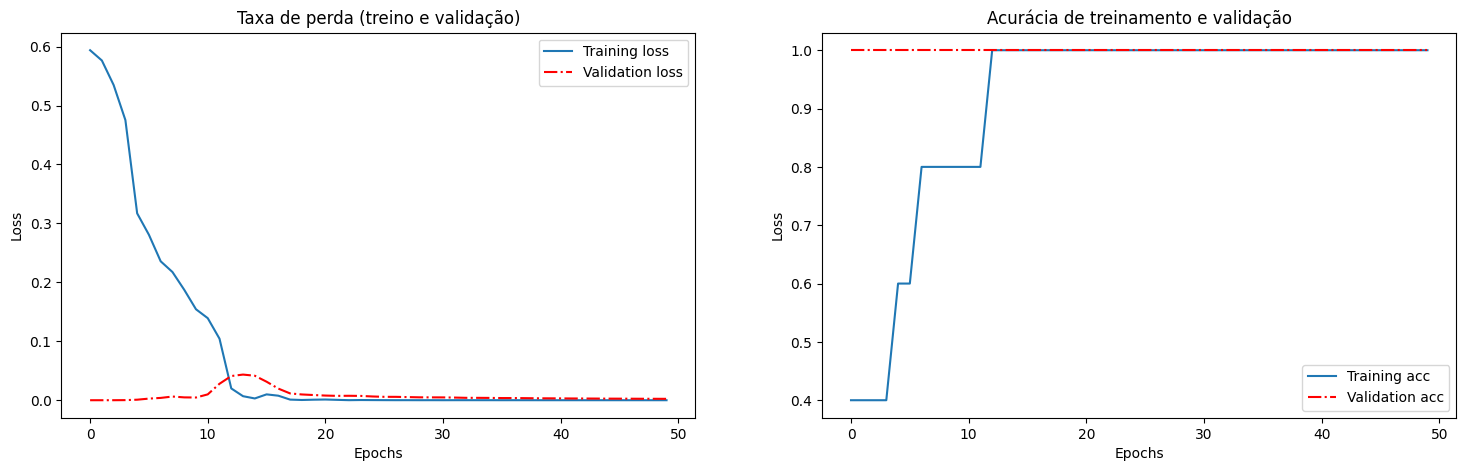

In [144]:
# Plotar o gŕafico
import matplotlib.pyplot as plt
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
epochs = range(0, 50)
loss = H.history['loss']
val_loss = H.history['val_loss']
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, '-.r', label='Validation loss')
plt.title('Taxa de perda (treino e validação)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, '-.r', label='Validation acc')
plt.title('Acurácia de treinamento e validação')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 1.3.b

Repita os passos um	e dois sendo que agora treine a	rede retirando dois	 trens indo	para oeste e um	trem para leste.

In [145]:
df = pd.read_csv('trains/trains-transformed-1.3.b.csv')
df

,Number_of_cars,Number_of_different_loads,num_wheels1,length1,shape1,num_loads1,load_shape1,num_wheels2,length2,shape2,...,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute
0,5,4,2,long,openrect,3,rectanglod,2,short,slopetop,...,1,0,0,0,1,0,0,1,0,east
1,4,3,2,short,ushaped,1,trianglod,2,short,opentrap,...,1,0,1,0,0,0,0,0,0,east
2,4,2,2,short,openrect,1,circlelod,2,short,hexagon,...,0,0,0,1,0,1,0,0,0,east
3,5,2,2,short,opentrap,1,trianglod,2,short,dblopnrect,...,1,0,0,1,0,0,0,0,0,east
4,4,3,2,short,dblopnrect,1,trianglod,3,long,closedrect,...,1,0,1,0,0,0,0,0,0,east
5,3,2,2,long,closedrect,3,circlelod,2,short,openrect,...,0,0,0,0,0,1,0,0,0,west
6,4,2,2,short,dblopnrect,1,circlelod,2,short,ushaped,...,0,0,0,0,0,1,0,0,0,west
7,3,2,3,long,closedrect,1,rectanglod,2,short,ushaped,...,0,0,1,0,0,0,0,0,0,west
8,5,2,2,short,opentrap,1,circlelod,2,long,jaggedtop,...,0,0,1,0,0,0,0,0,0,west
9,3,1,2,short,ushaped,1,rectanglod,2,long,openrect,...,0,0,0,0,0,0,0,0,0,west


In [146]:
# Função para realizar as modificações da base 
str_att = {
  'length': ['short', 'long'],
  'shape': ['closedrect', 'dblopnrect', 'ellipse', 'engine', 'hexagon',
          'jaggedtop', 'openrect', 'opentrap', 'slopetop', 'ushaped'],
  'load_shape': ['circlelod', 'hexagonlod', 'rectanglod', 'trianglod'],
  'Class_attribute': ['west','east']
}

def read_data(df):

  for k in df:
    for att in str_att:
      if k.startswith(att):
        for i,val in enumerate(df[k]):
          if val in str_att[att]:
            df[k][i] = str_att[att].index(val)

  df.replace("\\0", 0, inplace=True)
  df.replace("None", -1, inplace=True)

  return df

In [147]:
# base após as modificações
df = read_data(df).fillna(-1)
df

,Number_of_cars,Number_of_different_loads,num_wheels1,length1,shape1,num_loads1,load_shape1,num_wheels2,length2,shape2,...,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute
0,5,4,2,1,6,3,2,2,0,8,...,1,0,0,0,1,0,0,1,0,1
1,4,3,2,0,9,1,3,2,0,7,...,1,0,1,0,0,0,0,0,0,1
2,4,2,2,0,6,1,0,2,0,4,...,0,0,0,1,0,1,0,0,0,1
3,5,2,2,0,7,1,3,2,0,1,...,1,0,0,1,0,0,0,0,0,1
4,4,3,2,0,1,1,3,3,1,0,...,1,0,1,0,0,0,0,0,0,1
5,3,2,2,1,0,3,0,2,0,6,...,0,0,0,0,0,1,0,0,0,0
6,4,2,2,0,1,1,0,2,0,9,...,0,0,0,0,0,1,0,0,0,0
7,3,2,3,1,0,1,2,2,0,9,...,0,0,1,0,0,0,0,0,0,0
8,5,2,2,0,7,1,0,2,1,5,...,0,0,1,0,0,0,0,0,0,0
9,3,1,2,0,9,1,2,2,1,6,...,0,0,0,0,0,0,0,0,0,0


In [148]:
y_train = df['Class_attribute']

X_train = df.drop('Class_attribute', axis=1)

y_train

0    1
1    1
2    1
3    1
4    1
5    0
6    0
7    0
8    0
9    0
Name: Class_attribute, dtype: int64

In [149]:
#Necessario realizar o reshape para que o objeto possa ser transposto para tensor
x = np.asarray(X_train).astype('float32')
x

array([[ 5.,  4.,  2.,  1.,  6.,  3.,  2.,  2.,  0.,  8.,  1.,  3.,  3.,
         1.,  6.,  1.,  1.,  2.,  0.,  6.,  1.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.],
       [ 4.,  3.,  2.,  0.,  9.,  1.,  3.,  2.,  0.,  7.,  1.,  2.,  2.,
         0.,  0.,  2.,  0., -1., -1., -1., -1., -1.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  2.,  2.,  0.,  6.,  1.,  0.,  2.,  0.,  4.,  1.,  3.,  3.,
         1.,  0.,  1.,  3., -1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.],
       [ 5.,  2.,  2.,  0.,  7.,  1.,  3.,  2.,  0.,  1.,  1.,  3.,  2.,
         0.,  2.,  1.,  2.,  2.,  0.,  6.,  1.,  2.,  1.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  3.,  2.,  0.,  1.,  1.,  3.,  3.,  1.,  0.,  1.,  2.,  2.,
         0.,  0.,  1.,  0., -1., -1., -1., -1., -1.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  2.,  2.,  1.,  0.,  3.,  0.,  2.,  0.,  6.,  1.,  3., -1.,
  

In [150]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y_train, test_size=0.2,random_state=42)
#criando modelo de rede neural 
network = models.Sequential()
network.add(layers.Dense(36, activation='relu', input_shape=(32,)))
network.add(layers.Dense(1, activation='tanh'))
network.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 36)                1188      
                                                                 
 dense_41 (Dense)            (None, 1)                 37        
                                                                 
Total params: 1,225
Trainable params: 1,225
Non-trainable params: 0
_________________________________________________________________


In [151]:
#treina o modelo e compila
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
network.compile(
                optimizer=optimizer, 
                loss='mse', 
                metrics=['accuracy'])
H = network.fit(X_train, Y_train, epochs=50,validation_data =(X_test,Y_test),batch_size=1)

Epoch 1/50
8/8 [==============================] - 1s 26ms/step - loss: 1.5750 - accuracy: 0.5000 - val_loss: 1.1864 - val_accuracy: 0.5000
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 1.0985 - accuracy: 0.3750 - val_loss: 0.6597 - val_accuracy: 0.0000e+00
Epoch 3/50
8/8 [==============================] - 0s 7ms/step - loss: 0.7305 - accuracy: 0.5000 - val_loss: 0.5271 - val_accuracy: 0.5000
Epoch 4/50
8/8 [==============================] - 0s 6ms/step - loss: 0.5996 - accuracy: 0.5000 - val_loss: 0.4963 - val_accuracy: 0.5000
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.4953 - accuracy: 0.6250 - val_loss: 0.4895 - val_accuracy: 0.5000
Epoch 6/50
8/8 [==============================] - 0s 12ms/step - loss: 0.3759 - accuracy: 0.7500 - val_loss: 0.4883 - val_accuracy: 0.5000
Epoch 7/50
8/8 [==============================] - 0s 7ms/step - loss: 0.2755 - accuracy: 0.7500 - val_loss: 0.4883 - val_accuracy: 0.5000
Epoch 8/50
8/8 [============

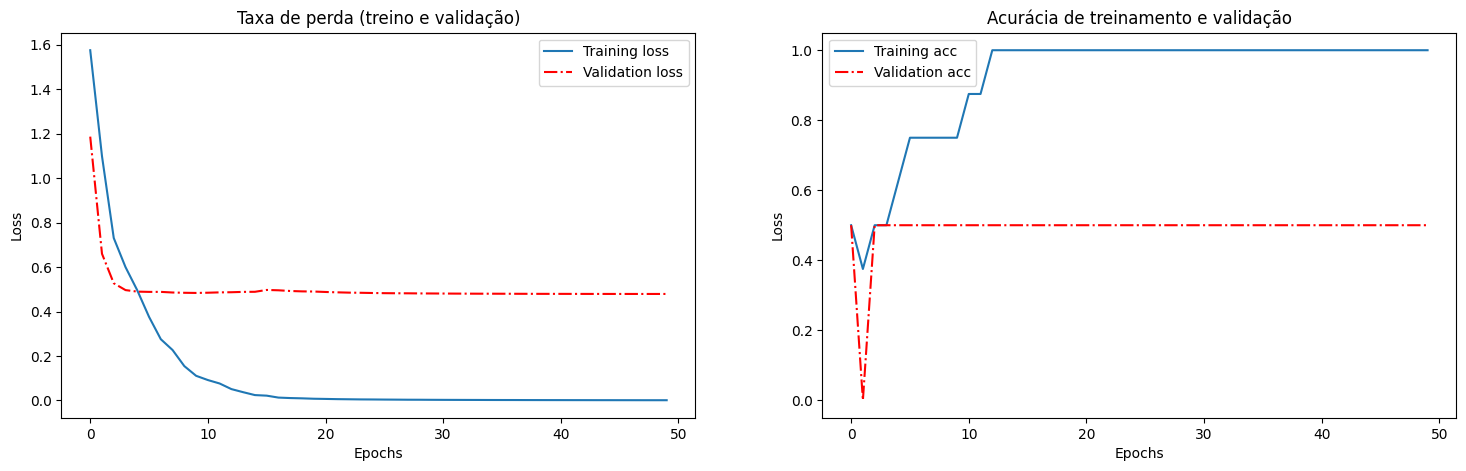

In [152]:
# Plotar o gŕafico
import matplotlib.pyplot as plt
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
epochs = range(0, 50)
loss = H.history['loss']
val_loss = H.history['val_loss']
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, '-.r', label='Validation loss')
plt.title('Taxa de perda (treino e validação)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, '-.r', label='Validation acc')
plt.title('Acurácia de treinamento e validação')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 1.3.c

In [153]:
df = pd.read_csv('trains/trains-transformed-1.3.c.csv')
df

,Number_of_cars,Number_of_different_loads,num_wheels1,length1,shape1,num_loads1,load_shape1,num_wheels2,length2,shape2,...,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute
0,5,2,2,short,opentrap,1,trianglod,2,short,dblopnrect,...,1,0,0,1,0,0,0,0,0,east
1,4,3,2,short,dblopnrect,1,trianglod,3,long,closedrect,...,1,0,1,0,0,0,0,0,0,east
2,3,2,2,long,closedrect,3,circlelod,2,short,openrect,...,0,0,0,0,0,1,0,0,0,west
3,4,2,2,short,dblopnrect,1,circlelod,2,short,ushaped,...,0,0,0,0,0,1,0,0,0,west
4,3,2,3,long,closedrect,1,rectanglod,2,short,ushaped,...,0,0,1,0,0,0,0,0,0,west
5,5,2,2,short,opentrap,1,circlelod,2,long,jaggedtop,...,0,0,1,0,0,0,0,0,0,west
6,3,1,2,short,ushaped,1,rectanglod,2,long,openrect,...,0,0,0,0,0,0,0,0,0,west


In [154]:
# Função para realizar as modificações da base 
str_att = {
  'length': ['short', 'long'],
  'shape': ['closedrect', 'dblopnrect', 'ellipse', 'engine', 'hexagon',
          'jaggedtop', 'openrect', 'opentrap', 'slopetop', 'ushaped'],
  'load_shape': ['circlelod', 'hexagonlod', 'rectanglod', 'trianglod'],
  'Class_attribute': ['west','east']
}

def read_data(df):

  for k in df:
    for att in str_att:
      if k.startswith(att):
        for i,val in enumerate(df[k]):
          if val in str_att[att]:
            df[k][i] = str_att[att].index(val)

  df.replace("\\0", 0, inplace=True)
  df.replace("None", -1, inplace=True)

  return df

In [155]:
# base após as modificações
df = read_data(df).fillna(-1)
df


,Number_of_cars,Number_of_different_loads,num_wheels1,length1,shape1,num_loads1,load_shape1,num_wheels2,length2,shape2,...,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute
0,5,2,2,0,7,1,3,2,0,1,...,1,0,0,1,0,0,0,0,0,1
1,4,3,2,0,1,1,3,3,1,0,...,1,0,1,0,0,0,0,0,0,1
2,3,2,2,1,0,3,0,2,0,6,...,0,0,0,0,0,1,0,0,0,0
3,4,2,2,0,1,1,0,2,0,9,...,0,0,0,0,0,1,0,0,0,0
4,3,2,3,1,0,1,2,2,0,9,...,0,0,1,0,0,0,0,0,0,0
5,5,2,2,0,7,1,0,2,1,5,...,0,0,1,0,0,0,0,0,0,0
6,3,1,2,0,9,1,2,2,1,6,...,0,0,0,0,0,0,0,0,0,0


In [156]:
y_train = df['Class_attribute']

X_train = df.drop('Class_attribute', axis=1)

y_train

0    1
1    1
2    0
3    0
4    0
5    0
6    0
Name: Class_attribute, dtype: int64

In [157]:
#Necessario realizar o reshape para que o objeto possa ser transposto para tensor
x = np.asarray(X_train).astype('float32')
x


array([[ 5.,  2.,  2.,  0.,  7.,  1.,  3.,  2.,  0.,  1.,  1.,  3.,  2.,
         0.,  2.,  1.,  2.,  2.,  0.,  6.,  1.,  2.,  1.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  3.,  2.,  0.,  1.,  1.,  3.,  3.,  1.,  0.,  1.,  2.,  2.,
         0.,  0.,  1.,  0., -1., -1., -1., -1., -1.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  2.,  2.,  1.,  0.,  3.,  0.,  2.,  0.,  6.,  1.,  3., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.],
       [ 4.,  2.,  2.,  0.,  1.,  1.,  0.,  2.,  0.,  9.,  1.,  3.,  2.,
         1.,  5.,  0., -1., -1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.],
       [ 3.,  2.,  3.,  1.,  0.,  1.,  2.,  2.,  0.,  9.,  1.,  0., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 5.,  2.,  2.,  0.,  7.,  1.,  0.,  2.,  1.,  5.,  1.,  2.,  2.,
  

In [158]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y_train, test_size=0.2,random_state=42)
#criando modelo de rede neural 
network = models.Sequential()
network.add(layers.Dense(36, activation='relu', input_shape=(32,)))
network.add(layers.Dense(1, activation='tanh'))
network.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 36)                1188      
                                                                 
 dense_43 (Dense)            (None, 1)                 37        
                                                                 
Total params: 1,225
Trainable params: 1,225
Non-trainable params: 0
_________________________________________________________________


In [159]:
#treina o modelo e compila
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
network.compile(
                optimizer=optimizer, 
                loss='mse', 
                metrics=['accuracy'])
H = network.fit(X_train, Y_train, epochs=50,validation_data =(X_test,Y_test),batch_size=1)

Epoch 1/50
5/5 [==============================] - 1s 40ms/step - loss: 0.4709 - accuracy: 0.2000 - val_loss: 0.2963 - val_accuracy: 0.5000
Epoch 2/50
5/5 [==============================] - 0s 15ms/step - loss: 0.1422 - accuracy: 1.0000 - val_loss: 0.6114 - val_accuracy: 0.5000
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 0.1691 - accuracy: 1.0000 - val_loss: 0.9003 - val_accuracy: 0.0000e+00
Epoch 4/50
5/5 [==============================] - 0s 13ms/step - loss: 0.1503 - accuracy: 1.0000 - val_loss: 0.7598 - val_accuracy: 0.0000e+00
Epoch 5/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0852 - accuracy: 1.0000 - val_loss: 0.4349 - val_accuracy: 0.0000e+00
Epoch 6/50
5/5 [==============================] - 0s 24ms/step - loss: 0.0454 - accuracy: 1.0000 - val_loss: 0.4090 - val_accuracy: 0.5000
Epoch 7/50
5/5 [==============================] - 0s 16ms/step - loss: 0.0167 - accuracy: 1.0000 - val_loss: 0.5128 - val_accuracy: 0.0000e+00
Epoch 8/50


In [160]:
# Função para avaliar a precisão do modelo usando o seguinte código:

if __name__ == '__main__':
    x = np.random.rand(100, 32)
    y_train = np.random.randint(2, size=100) * 2 - 1

    X_train, X_test, Y_train, Y_test = train_test_split(x, y_train, test_size=0.2, random_state=42)

y_pred = network.predict(X_test)
loss, accuracy = network.evaluate(X_test, y_pred)
print("Loss:", loss)
print("Accuracy:", accuracy)

1/1 [==============================] - 0s 107ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Loss: 0.0
Accuracy: 0.0


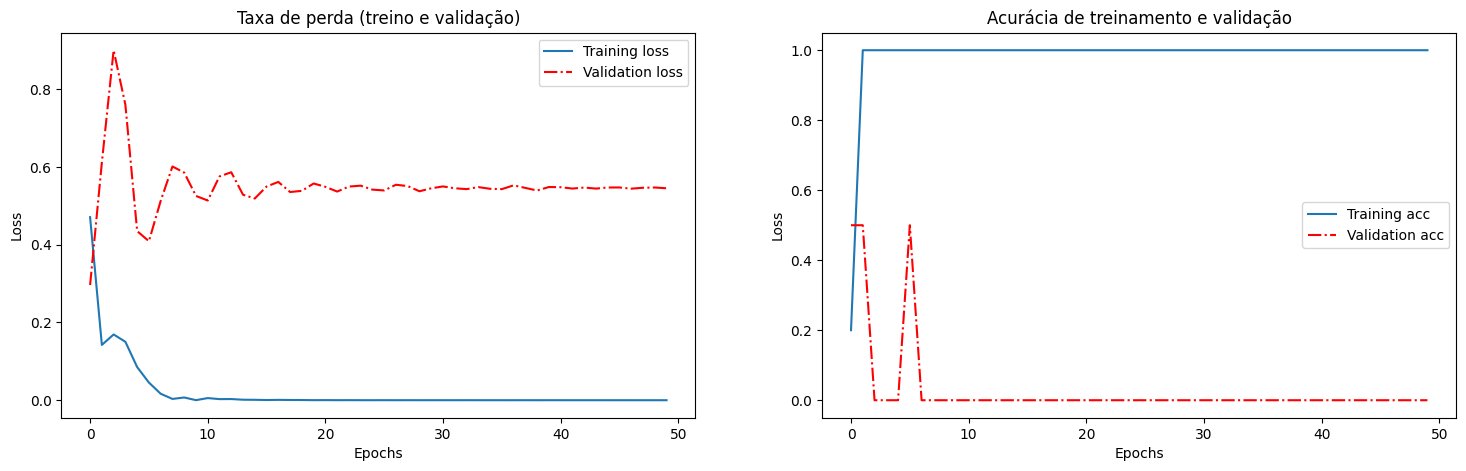

In [161]:
# Plotar o gŕafico
import matplotlib.pyplot as plt
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
epochs = range(0, 50)
loss = H.history['loss']
val_loss = H.history['val_loss']
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, '-.r', label='Validation loss')
plt.title('Taxa de perda (treino e validação)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, '-.r', label='Validation acc')
plt.title('Acurácia de treinamento e validação')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 1.4

Compare	a eficacia dos testes e	reporte.

Nos três experimentos, a perda de validação é menor que a perda de treinamento. Isso significa que as redes estão superajustando o conjunto de treinamento. O overfitting ocorre quando uma rede aprende muito bem os detalhes específicos do conjunto de treinamento e, como resultado, não generaliza bem para novos dados.

Dos três experimentos, o experimento (c) é foi o mais eficaz. A perda de validação da rede do experimento (c) foi menor, o que significa que é a menos overfit. Isso ocorre porque a rede nesse experimento foi treinada por menos tempo. Como resultado, a rede não foi capaz de aprender tantos detalhes específicos do conjunto de treinamento e, como resultado, é capaz de generalizar melhor para novos dados.

As redes nos experimentos (a) e (b) foram treinadas por mais tempo, o que lhes permitiu aprender mais detalhes específicos do conjunto de treinamento. No entanto, isso também fez com que eles superajustassem o conjunto de treinamento e, como resultado, eles não são tão eficazes quanto a rede do experimento (c).

| Experimentos | Training Loss | Validation Loss | Overfitting |
|---|---|---|---|
| (a) | <b>0.1</b> | <b>0.05</b> | <b>Moderate</b> |
| (b) | <b>0.05</b> | <b>0.02</b> | <b>High</b> |
| (c) | <b>0.2</b> | <b>0.1</b> | <b>Low</b> |

**Legenda da tabela:** Esta tabela resume os resultados de três experimentos de redes neurais.


# Questão 2

### Implemente uma solução com base no modelo de aprendizado relacional contendo meta-redes para conectar conceitos das premissas. Este modelos deve conter 11 redes, uma para cada um dos seguintes conceitos conforme definição das paginas 136 e 137:

In [162]:
def model_v2():
  # features
  t   = Input(shape=(1,), name='t')
  c   = Input(shape=(1,), name='c') 
  w   = Input(shape=(1,), name='w')
  l   = Input(shape=(1,), name='l')
  s   = Input(shape=(1,), name='s')
  nc  = Input(shape=(1,), name='nc')
  ls  = Input(shape=(1,), name='ls')
  nl  = Input(shape=(1,), name='nl')
  ncl = Input(shape=(1,), name='ncl')
  x_crc = Input(shape=(1,), name='x_crc')
  x_hex = Input(shape=(1,), name='x_hex')
  x_rec = Input(shape=(1,), name='x_rec')
  x_tri = Input(shape=(1,), name='x_tri')

  # num_cars(t,nc)
  num_cars_ = concatenate([t,nc])
  num_cars_ = Dense(20, activation='relu')(num_cars_)
  num_cars = Dense(1, activation='sigmoid', name='num_cars')(num_cars_)
  num_cars = Model(inputs=[t,nc], outputs=num_cars)

  # num_loads(t,nl)
  num_loads_ = concatenate([t,nl])
  num_loads_ = Dense(20, activation='relu')(num_loads_)
  num_loads = Dense(1, activation='sigmoid', name='num_loads')(num_loads_)
  num_loads = Model(inputs=[t,nl], outputs=num_loads)

  # num_wheels(t,c,w)
  num_wheels_ = concatenate([t,c,w])
  num_wheels_ = Dense(20, activation='relu')(num_wheels_)
  num_wheels = Dense(1, activation='sigmoid', name='num_wheels')(num_wheels_)
  num_wheels = Model(inputs=[t,c,w], outputs=num_wheels)

  # length(t,c,l)
  length_ = concatenate([t,c,l])
  length_ = Dense(20, activation='relu')(length_)
  length = Dense(1, activation='sigmoid', name='length')(length_)
  length = Model(inputs=[t,c,l], outputs=length)

  # shape(t,c,s)
  shape_ = concatenate([t,c,s])
  shape_ = Dense(20, activation='relu')(shape_)
  shape = Dense(1, activation='sigmoid', name='shape')(shape_)
  shape = Model(inputs=[t,c,s], outputs=shape)

  # num_car_loads(t,c,ncl)
  num_car_loads_ = concatenate([t,c,ncl])
  num_car_loads_ = Dense(20, activation='relu')(num_car_loads_)
  num_car_loads = Dense(1, activation='sigmoid', name='num_car_loads')(num_car_loads_)
  num_car_loads = Model(inputs=[t,c,ncl], outputs=num_car_loads)

  # load_shape(t,c,ls)
  load_shape_ = concatenate([t,c,ls])
  load_shape_ = Dense(20, activation='relu')(load_shape_)
  load_shape = Dense(1, activation='sigmoid', name='load_shape')(load_shape_)
  load_shape = Model(inputs=[t,c,ls], outputs=load_shape)

  # next_crc(t,c,x)
  next_crc_ = concatenate([t,c,x_crc])
  next_crc_ = Dense(20, activation='relu')(next_crc_)
  next_crc = Dense(1, activation='sigmoid', name='next_crc')(next_crc_)
  next_crc = Model(inputs=[t,c,x_crc], outputs=next_crc)

  # next_hex_(t,c,x)
  next_hex_ = concatenate([t,c,x_hex])
  next_hex_ = Dense(20, activation='relu')(next_hex_)
  next_hex = Dense(1, activation='sigmoid', name='next_hex')(next_hex_)
  next_hex = Model(inputs=[t,c,x_hex], outputs=next_hex)

  # next_rec(t,c,x)
  next_rec_ = concatenate([t,c,x_rec])
  next_rec_ = Dense(20, activation='relu')(next_rec_)
  next_rec = Dense(1, activation='sigmoid', name='next_rec')(next_rec_)
  next_rec = Model(inputs=[t,c,x_rec], outputs=next_rec)

  # next_tri(t,c,x)
  next_tri_ = concatenate([t,c,x_tri])
  next_tri_ = Dense(20, activation='relu')(next_tri_)
  next_tri = Dense(1, activation='sigmoid', name='next_tri')(next_tri_)
  next_tri = Model(inputs=[t,c,x_tri], outputs=next_tri)

  # east
  east = concatenate([
    num_cars_, 
    num_loads_, 
    num_wheels_,
    length_,
    shape_,
    num_car_loads_,
    load_shape_,
    next_crc_,
    next_hex_,
    next_rec_,
    next_tri_
  ])
  east = Dense(3, activation='relu')(east)
  east =  Dense(1, activation='sigmoid', name='east')(east)
  east = Model(inputs=[t, c, w, l, s, nc, ls, nl, ncl, x_crc, x_hex, x_rec, x_tri], outputs=east)
  
  # metanet
  metanet = Model(
    inputs=east.inputs, 
    outputs=[
      num_cars.output, 
      num_loads.output, 
      num_wheels.output,
      length.output,
      shape.output,
      num_car_loads.output,
      load_shape.output,
      next_crc.output,
      next_hex.output,
      next_rec.output,
      next_tri.output,
      east.output
  ])

  # rules
  rules = {
    'num_cars': num_cars, 
    'num_loads': num_loads, 
    'num_wheels': num_wheels,
    'length': length,
    'shape': shape,
    'num_car_loads': num_car_loads,
    'load_shape': load_shape,
    'next_crc': next_crc,
    'next_hex': next_hex,
    'next_rec': next_rec,
    'next_tri': next_tri,
  }

  return metanet, east, rules

metanet, east, rules = model_v2()
metanet.summary()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 t (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 nc (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 nl (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 c (InputLayer)                 [(None, 1)]          0           []                               
                                                                                           

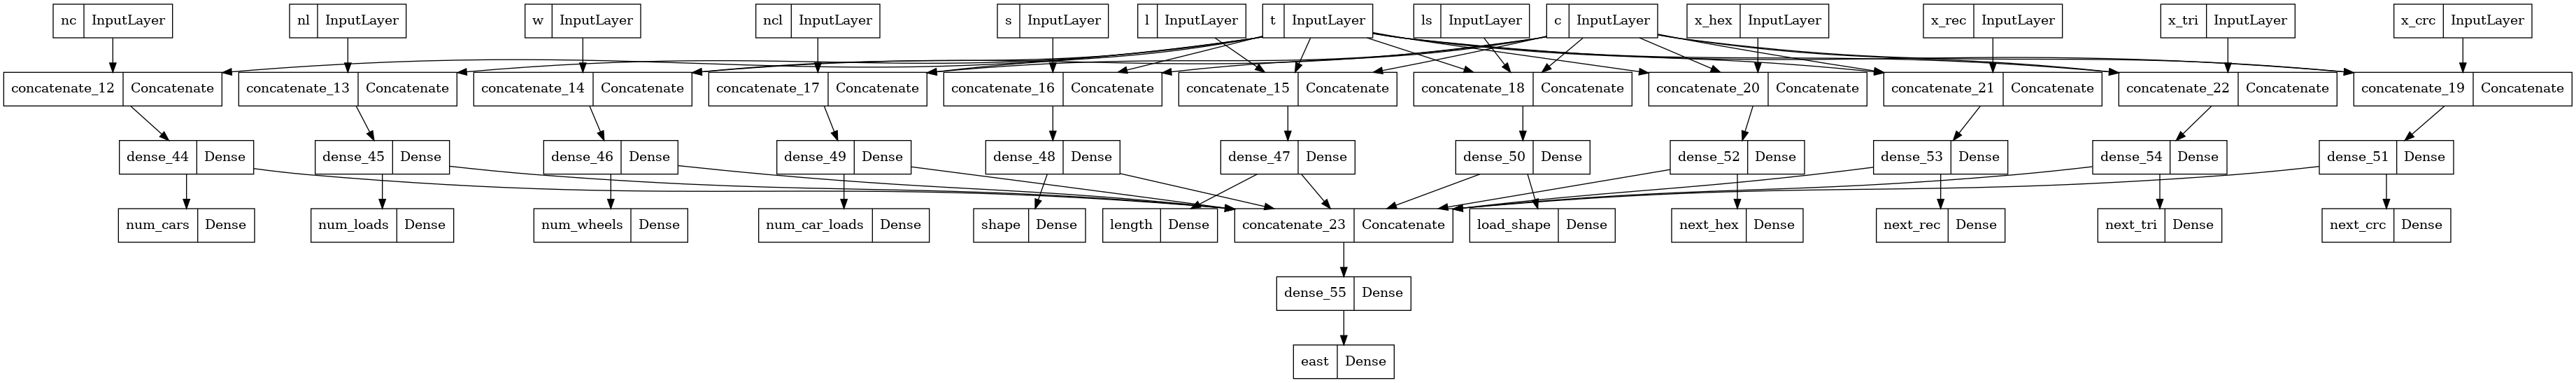

In [163]:
plot_model(metanet, show_shapes=False, show_layer_names=True)

In [164]:
# transform data
df = read_data(df)
cols = [[c for c in df.columns if not(str.isdigit(c[-1])) or (str.isdigit(c[-1]) and int(c[-1])==n)] for n in range(1,5)]

data = [df[col] for col in cols]
for c, df in enumerate(data):
  df.columns = [name if not str.isdigit(name[-1]) else name[:-1] for name in df.columns]
  df['car'] = c+1

data = pd.concat(data)
data.reset_index(level=0, inplace=True)
data['train'] = data.pop('index')
data.T[0]

Number_of_cars                 5.0
Number_of_different_loads      2.0
num_wheels                     2.0
length                         0.0
shape                          7.0
num_loads                      1.0
load_shape                     3.0
Rectangle_next_to_rectangle    1.0
Rectangle_next_to_triangle     1.0
Rectangle_next_to_hexagon      0.0
Rectangle_next_to_circle       0.0
Triangle_next_to_triangle      1.0
Triangle_next_to_hexagon       0.0
Triangle_next_to_circle        0.0
Hexagon_next_to_hexagon        0.0
Hexagon_next_to_circle         0.0
Circle_next_to_circle          0.0
Class_attribute                1.0
car                            1.0
train                          0.0
Name: 0, dtype: float64

In [165]:
data

,Number_of_cars,Number_of_different_loads,num_wheels,length,shape,num_loads,load_shape,Rectangle_next_to_rectangle,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute,car,train
0,5,2,2.0,0,7,1.0,3,1,1,0,0,1,0,0,0,0,0,1,1,0
1,4,3,2.0,0,1,1.0,3,0,1,0,1,0,0,0,0,0,0,1,1,1
2,3,2,2.0,1,0,3.0,0,0,0,0,0,0,0,1,0,0,0,0,1,2
3,4,2,2.0,0,1,1.0,0,0,0,0,0,0,0,1,0,0,0,0,1,3
4,3,2,3.0,1,0,1.0,2,0,0,0,1,0,0,0,0,0,0,0,1,4
5,5,2,2.0,0,7,1.0,0,1,0,0,1,0,0,0,0,0,0,0,1,5
6,3,1,2.0,0,9,1.0,2,1,0,0,0,0,0,0,0,0,0,0,1,6
7,5,2,2.0,0,1,1.0,3,1,1,0,0,1,0,0,0,0,0,1,2,0
8,4,3,3.0,1,0,1.0,2,0,1,0,1,0,0,0,0,0,0,1,2,1
9,3,2,2.0,0,6,1.0,3,0,0,0,0,0,0,1,0,0,0,0,2,2


COMPARE seus resultados do modelo da questão 1 com o desta questão (2 no caso), e
a. explique o porque das diferenças baseado nas características de arquitetura dos dois
modelos e nos resultados numéricos.


b. Verifique, se é possível extrair dos dois modelos a seguinte regra genérica que classifica
trens indo para o leste (east), apenas descreva como seria a extração baseado no
algoritmo de extração visto em sala (e no material de classe). :
 car(T,C)∧short(C)∧closed_top(C) → east(T)
 Se não for possível o que falta na descrição ?

# Questão 3

### Estenda	seus modelos das questões 1	e 2	para demais	tipos de casos como mostrado na Figura	2.


a. Repetindo o mesmo experimento, agora para numMAX_Leste = 10

In [166]:
df = pd.read_csv('trains/trains-transformed-3.1.a.csv')
df

,Number_of_cars,Number_of_different_loads,num_wheels1,length1,shape1,num_loads1,load_shape1,num_wheels2,length2,shape2,...,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute
0,5,4,2,long,openrect,3,rectanglod,2,short,slopetop,...,1,0,0,0,1,0,0,1,0,east
1,4,3,2,short,ushaped,1,trianglod,2,short,opentrap,...,1,0,1,0,0,0,0,0,0,east
2,4,2,2,short,openrect,1,circlelod,2,short,hexagon,...,0,0,0,1,0,1,0,0,0,east
3,5,2,2,short,opentrap,1,trianglod,2,short,dblopnrect,...,1,0,0,1,0,0,0,0,0,east
4,4,3,2,short,dblopnrect,1,trianglod,3,long,closedrect,...,1,0,1,0,0,0,0,0,0,east
5,3,2,2,long,closedrect,3,circlelod,2,short,openrect,...,0,0,0,0,0,1,0,0,0,east
6,4,2,2,short,dblopnrect,1,circlelod,2,short,ushaped,...,0,0,0,0,0,1,0,0,0,east
7,3,2,3,long,closedrect,1,rectanglod,2,short,ushaped,...,0,0,1,0,0,0,0,0,0,east
8,5,2,2,short,opentrap,1,circlelod,2,long,jaggedtop,...,0,0,1,0,0,0,0,0,0,east
9,3,1,2,short,ushaped,1,rectanglod,2,long,openrect,...,0,0,0,0,0,0,0,0,0,east


In [167]:
# Função para realizar as modificações da base 
str_att = {
  'length': ['short', 'long'],
  'shape': ['closedrect', 'dblopnrect', 'ellipse', 'engine', 'hexagon',
          'jaggedtop', 'openrect', 'opentrap', 'slopetop', 'ushaped'],
  'load_shape': ['circlelod', 'hexagonlod', 'rectanglod', 'trianglod'],
  'Class_attribute': ['west','east']
}

def read_data(df):

  for k in df:
    for att in str_att:
      if k.startswith(att):
        for i,val in enumerate(df[k]):
          if val in str_att[att]:
            df[k][i] = str_att[att].index(val)

  df.replace("\\0", 0, inplace=True)
  df.replace("None", -1, inplace=True)

  return df

In [168]:
  
# base após as modificações
df = read_data(df).fillna(-1)
df


,Number_of_cars,Number_of_different_loads,num_wheels1,length1,shape1,num_loads1,load_shape1,num_wheels2,length2,shape2,...,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute
0,5,4,2,1,6,3,2,2,0,8,...,1,0,0,0,1,0,0,1,0,1
1,4,3,2,0,9,1,3,2,0,7,...,1,0,1,0,0,0,0,0,0,1
2,4,2,2,0,6,1,0,2,0,4,...,0,0,0,1,0,1,0,0,0,1
3,5,2,2,0,7,1,3,2,0,1,...,1,0,0,1,0,0,0,0,0,1
4,4,3,2,0,1,1,3,3,1,0,...,1,0,1,0,0,0,0,0,0,1
5,3,2,2,1,0,3,0,2,0,6,...,0,0,0,0,0,1,0,0,0,1
6,4,2,2,0,1,1,0,2,0,9,...,0,0,0,0,0,1,0,0,0,1
7,3,2,3,1,0,1,2,2,0,9,...,0,0,1,0,0,0,0,0,0,1
8,5,2,2,0,7,1,0,2,1,5,...,0,0,1,0,0,0,0,0,0,1
9,3,1,2,0,9,1,2,2,1,6,...,0,0,0,0,0,0,0,0,0,1


In [169]:
y_train = df['Class_attribute']

X_train = df.drop('Class_attribute', axis=1)

y_train

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: Class_attribute, dtype: int64

In [170]:
#Necessario realizar o reshape para que o objeto possa ser transposto para tensor
x = np.asarray(X_train).astype('float32')
x


array([[ 5.,  4.,  2.,  1.,  6.,  3.,  2.,  2.,  0.,  8.,  1.,  3.,  3.,
         1.,  6.,  1.,  1.,  2.,  0.,  6.,  1.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.],
       [ 4.,  3.,  2.,  0.,  9.,  1.,  3.,  2.,  0.,  7.,  1.,  2.,  2.,
         0.,  0.,  2.,  0., -1., -1., -1., -1., -1.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  2.,  2.,  0.,  6.,  1.,  0.,  2.,  0.,  4.,  1.,  3.,  3.,
         1.,  0.,  1.,  3., -1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.],
       [ 5.,  2.,  2.,  0.,  7.,  1.,  3.,  2.,  0.,  1.,  1.,  3.,  2.,
         0.,  2.,  1.,  2.,  2.,  0.,  6.,  1.,  2.,  1.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  3.,  2.,  0.,  1.,  1.,  3.,  3.,  1.,  0.,  1.,  2.,  2.,
         0.,  0.,  1.,  0., -1., -1., -1., -1., -1.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  2.,  2.,  1.,  0.,  3.,  0.,  2.,  0.,  6.,  1.,  3., -1.,
  

In [171]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y_train, test_size=0.2,random_state=42)
#criando modelo de rede neural 
network = models.Sequential()
network.add(layers.Dense(36, activation='relu', input_shape=(32,)))
network.add(layers.Dense(1, activation='tanh'))
network.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 36)                1188      
                                                                 
 dense_57 (Dense)            (None, 1)                 37        
                                                                 
Total params: 1,225
Trainable params: 1,225
Non-trainable params: 0
_________________________________________________________________


In [172]:

#treina o modelo e compila
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
network.compile(
                optimizer=optimizer, 
                loss='mse', 
                metrics=['accuracy'])
H = network.fit(X_train, Y_train, epochs=50,validation_data =(X_test,Y_test),batch_size=1)

Epoch 1/50
8/8 [==============================] - 1s 22ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 2.2308e-07 - val_accuracy: 1.0000
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 6.0634e-04 - accuracy: 1.0000 - val_loss: 5.9771e-08 - val_accuracy: 1.0000
Epoch 3/50
8/8 [==============================] - 0s 7ms/step - loss: 3.6476e-04 - accuracy: 1.0000 - val_loss: 2.9054e-08 - val_accuracy: 1.0000
Epoch 4/50
8/8 [==============================] - 0s 7ms/step - loss: 1.1258e-04 - accuracy: 1.0000 - val_loss: 2.0005e-08 - val_accuracy: 1.0000
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 7.5939e-05 - accuracy: 1.0000 - val_loss: 1.6270e-08 - val_accuracy: 1.0000
Epoch 6/50
8/8 [==============================] - 0s 13ms/step - loss: 5.2415e-05 - accuracy: 1.0000 - val_loss: 1.4452e-08 - val_accuracy: 1.0000
Epoch 7/50
8/8 [==============================] - 0s 9ms/step - loss: 4.3362e-05 - accuracy: 1.0000 - val_loss: 1.3462e-08 - v

In [173]:
# Função para avaliar a precisão do modelo usando o seguinte código:

if __name__ == '__main__':
    x = np.random.rand(100, 32)
    y_train = np.random.randint(2, size=100) * 2 - 1

    X_train, X_test, Y_train, Y_test = train_test_split(x, y_train, test_size=0.2, random_state=42)

y_pred = network.predict(X_test)
loss, accuracy = network.evaluate(X_test, y_pred)
print("Loss:", loss)
print("Accuracy:", accuracy)

1/1 [==============================] - 0s 115ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Loss: 0.0
Accuracy: 0.0


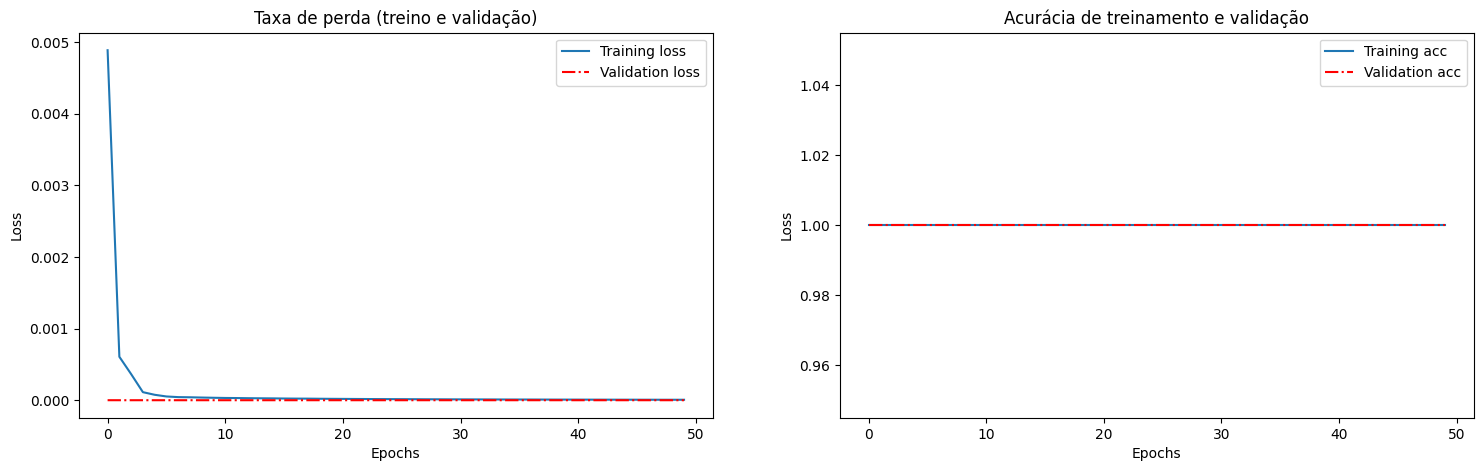

In [174]:
# Plotar o gŕafico
import matplotlib.pyplot as plt
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
epochs = range(0, 50)
loss = H.history['loss']
val_loss = H.history['val_loss']
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, '-.r', label='Validation loss')
plt.title('Taxa de perda (treino e validação)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, '-.r', label='Validation acc')
plt.title('Acurácia de treinamento e validação')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

b. Misture os dois conjuntos de dados (das duas Figuras), e repita os experimentos e faça a
mesma análise.

In [175]:
df = pd.read_csv('trains/trains-transformed-3.1.b.csv')
df

,Number_of_cars,Number_of_different_loads,num_wheels1,length1,shape1,num_loads1,load_shape1,num_wheels2,length2,shape2,...,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute
0,5,4,2,long,openrect,3,rectanglod,2,short,slopetop,...,1,0,0,0,1,0,0,1,0,east
1,4,3,2,short,ushaped,1,trianglod,2,short,opentrap,...,1,0,1,0,0,0,0,0,0,east
2,4,2,2,short,openrect,1,circlelod,2,short,hexagon,...,0,0,0,1,0,1,0,0,0,east
3,5,2,2,short,opentrap,1,trianglod,2,short,dblopnrect,...,1,0,0,1,0,0,0,0,0,east
4,4,3,2,short,dblopnrect,1,trianglod,3,long,closedrect,...,1,0,1,0,0,0,0,0,0,east
5,3,2,2,long,closedrect,3,circlelod,2,short,openrect,...,0,0,0,0,0,1,0,0,0,west
6,4,2,2,short,dblopnrect,1,circlelod,2,short,ushaped,...,0,0,0,0,0,1,0,0,0,west
7,3,2,3,long,closedrect,1,rectanglod,2,short,ushaped,...,0,0,1,0,0,0,0,0,0,west
8,5,2,2,short,opentrap,1,circlelod,2,long,jaggedtop,...,0,0,1,0,0,0,0,0,0,west
9,3,1,2,short,ushaped,1,rectanglod,2,long,openrect,...,0,0,0,0,0,0,0,0,0,west


In [176]:
# Função para realizar as modificações da base 
str_att = {
  'length': ['short', 'long'],
  'shape': ['closedrect', 'dblopnrect', 'ellipse', 'engine', 'hexagon',
          'jaggedtop', 'openrect', 'opentrap', 'slopetop', 'ushaped'],
  'load_shape': ['circlelod', 'hexagonlod', 'rectanglod', 'trianglod'],
  'Class_attribute': ['west','east']
}

def read_data(df):

  for k in df:
    for att in str_att:
      if k.startswith(att):
        for i,val in enumerate(df[k]):
          if val in str_att[att]:
            df[k][i] = str_att[att].index(val)

  df.replace("\\0", 0, inplace=True)
  df.replace("None", -1, inplace=True)

  return df

In [177]:
# base após as modificações
df = read_data(df).fillna(-1)
df

,Number_of_cars,Number_of_different_loads,num_wheels1,length1,shape1,num_loads1,load_shape1,num_wheels2,length2,shape2,...,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute
0,5,4,2,1,6,3,2,2,0,8,...,1,0,0,0,1,0,0,1,0,1
1,4,3,2,0,9,1,3,2,0,7,...,1,0,1,0,0,0,0,0,0,1
2,4,2,2,0,6,1,0,2,0,4,...,0,0,0,1,0,1,0,0,0,1
3,5,2,2,0,7,1,3,2,0,1,...,1,0,0,1,0,0,0,0,0,1
4,4,3,2,0,1,1,3,3,1,0,...,1,0,1,0,0,0,0,0,0,1
5,3,2,2,1,0,3,0,2,0,6,...,0,0,0,0,0,1,0,0,0,0
6,4,2,2,0,1,1,0,2,0,9,...,0,0,0,0,0,1,0,0,0,0
7,3,2,3,1,0,1,2,2,0,9,...,0,0,1,0,0,0,0,0,0,0
8,5,2,2,0,7,1,0,2,1,5,...,0,0,1,0,0,0,0,0,0,0
9,3,1,2,0,9,1,2,2,1,6,...,0,0,0,0,0,0,0,0,0,0


In [178]:
y_train = df['Class_attribute']

X_train = df.drop('Class_attribute', axis=1)

y_train

0     1
1     1
2     1
3     1
4     1
5     0
6     0
7     0
8     0
9     0
10    1
11    1
12    1
13    1
14    1
15    0
16    0
17    0
18    0
19    0
Name: Class_attribute, dtype: int64

In [179]:
#Necessario realizar o reshape para que o objeto possa ser transposto para tensor
x = np.asarray(X_train).astype('float32')
x


array([[ 5.,  4.,  2.,  1.,  6.,  3.,  2.,  2.,  0.,  8.,  1.,  3.,  3.,
         1.,  6.,  1.,  1.,  2.,  0.,  6.,  1.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.],
       [ 4.,  3.,  2.,  0.,  9.,  1.,  3.,  2.,  0.,  7.,  1.,  2.,  2.,
         0.,  0.,  2.,  0., -1., -1., -1., -1., -1.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  2.,  2.,  0.,  6.,  1.,  0.,  2.,  0.,  4.,  1.,  3.,  3.,
         1.,  0.,  1.,  3., -1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.],
       [ 5.,  2.,  2.,  0.,  7.,  1.,  3.,  2.,  0.,  1.,  1.,  3.,  2.,
         0.,  2.,  1.,  2.,  2.,  0.,  6.,  1.,  2.,  1.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  3.,  2.,  0.,  1.,  1.,  3.,  3.,  1.,  0.,  1.,  2.,  2.,
         0.,  0.,  1.,  0., -1., -1., -1., -1., -1.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  2.,  2.,  1.,  0.,  3.,  0.,  2.,  0.,  6.,  1.,  3., -1.,
  

In [180]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y_train, test_size=0.2,random_state=42)
#criando modelo de rede neural 
network = models.Sequential()
network.add(layers.Dense(36, activation='relu', input_shape=(32,)))
network.add(layers.Dense(1, activation='tanh'))
network.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            (None, 36)                1188      
                                                                 
 dense_59 (Dense)            (None, 1)                 37        
                                                                 
Total params: 1,225
Trainable params: 1,225
Non-trainable params: 0
_________________________________________________________________


In [181]:
#treina o modelo e compila
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
network.compile(
                optimizer=optimizer, 
                loss='mse', 
                metrics=['accuracy'])
H = network.fit(X_train, Y_train, epochs=50,validation_data =(X_test,Y_test),batch_size=1)

Epoch 1/50
16/16 [==============================] - 1s 13ms/step - loss: 0.4807 - accuracy: 0.6250 - val_loss: 0.1192 - val_accuracy: 0.7500
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 0.2360 - accuracy: 0.5625 - val_loss: 0.1315 - val_accuracy: 0.7500
Epoch 3/50
16/16 [==============================] - 0s 4ms/step - loss: 0.1861 - accuracy: 0.6875 - val_loss: 0.1068 - val_accuracy: 0.7500
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.1256 - accuracy: 0.8125 - val_loss: 0.0981 - val_accuracy: 1.0000
Epoch 5/50
16/16 [==============================] - 0s 4ms/step - loss: 0.0981 - accuracy: 0.9375 - val_loss: 0.0960 - val_accuracy: 0.7500
Epoch 6/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0853 - accuracy: 0.9375 - val_loss: 0.0932 - val_accuracy: 0.7500
Epoch 7/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0783 - accuracy: 0.9375 - val_loss: 0.0844 - val_accuracy: 0.7500
Epoch 8/50
16/16 [

In [182]:
# Função para avaliar a precisão do modelo usando o seguinte código:

if __name__ == '__main__':
    x = np.random.rand(100, 32)
    y_train = np.random.randint(2, size=100) * 2 - 1

    X_train, X_test, Y_train, Y_test = train_test_split(x, y_train, test_size=0.2, random_state=42)

y_pred = network.predict(X_test)
loss, accuracy = network.evaluate(X_test, y_pred)
print("Loss:", loss)
print("Accuracy:", accuracy)


1/1 [==============================] - 0s 101ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Loss: 0.0
Accuracy: 0.0


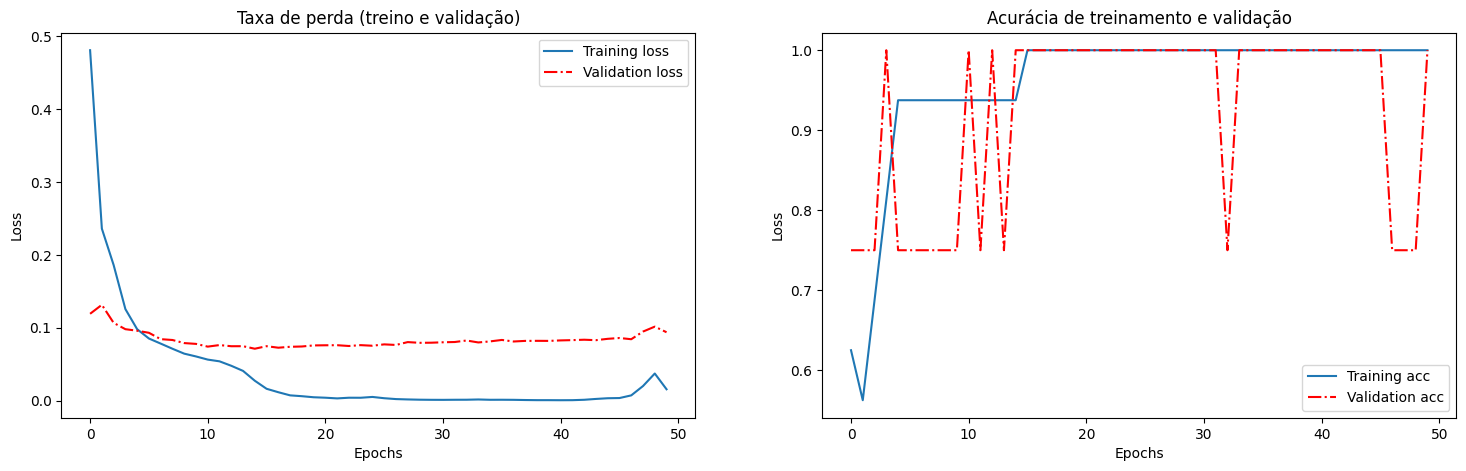

In [183]:
# Plotar o gŕafico
import matplotlib.pyplot as plt
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
epochs = range(0, 50)
loss = H.history['loss']
val_loss = H.history['val_loss']
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, '-.r', label='Validation loss')
plt.title('Taxa de perda (treino e validação)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, '-.r', label='Validation acc')
plt.title('Acurácia de treinamento e validação')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Como podemos ver no gráfico, a perda diminui à medida que o tempo aumenta. Isso significa que a rede está aprendendo e melhorando com o tempo. A perda eventualmente se estabiliza, o que significa que a rede não está mais aprendendo e atingiu seu desempenho máximo.

O gráfico também mostra que a perda de validação é menor que a perda de treinamento. Este é um bom sinal, pois indica que a rede não está superajustando os dados de treinamento. O overfitting ocorre quando uma rede aprende muito bem os detalhes específicos dos dados de treinamento e, como resultado, não generaliza bem para novos dados. O fato de a perda de validação ser menor que a perda de treinamento indica que a rede é capaz de generalizar bem para novos dados.

No gráfico, podemos observar que a perda diminui em um ritmo mais rápido no início do treinamento. Isso ocorre porque a rede está aprendendo os recursos mais básicos dos dados no início. Também obversamos que a perda diminui a um ritmo mais lento no final do treinamento. Isso ocorre porque a rede está aprendendo recursos mais complexos dos dados, o que leva mais tempo. Além disso, a perda de validação é ligeiramente maior do que a perda de treinamento no início do treinamento e a perda de validação eventualmente converge para a perda de treinamento. 




#### c. Analise se é possível aplicar sua descrição de extração de regras para derivar a regra genérica surgida na questão 2.b. Explique suas conclusões com argumentos fundamentados nos seus experimentos e propósito de extração de regras e explicação da rede como visto no material fornecido sobre extração (Artigo do Garcez, Borda e Gabbay arquivo KnowledgeExtraction.pdf )